In [2]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
torch.__version__

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


'2.0.1'

In [3]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=1000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[64]*11
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=0)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
591664
Data shapes: 1450.0 200.0


KeyboardInterrupt: 

Medium: (1450, 400), Rho: (4000, 400), B: (4000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
8281000
Data shapes: 1450.0 200.0


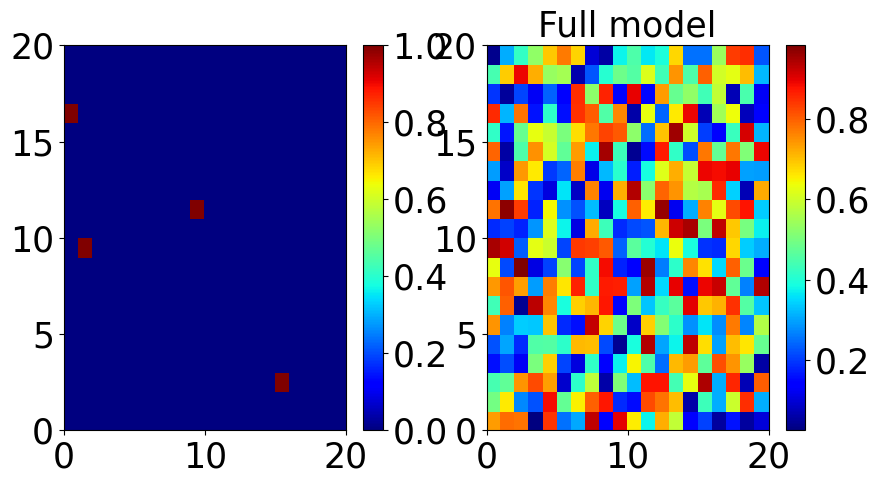

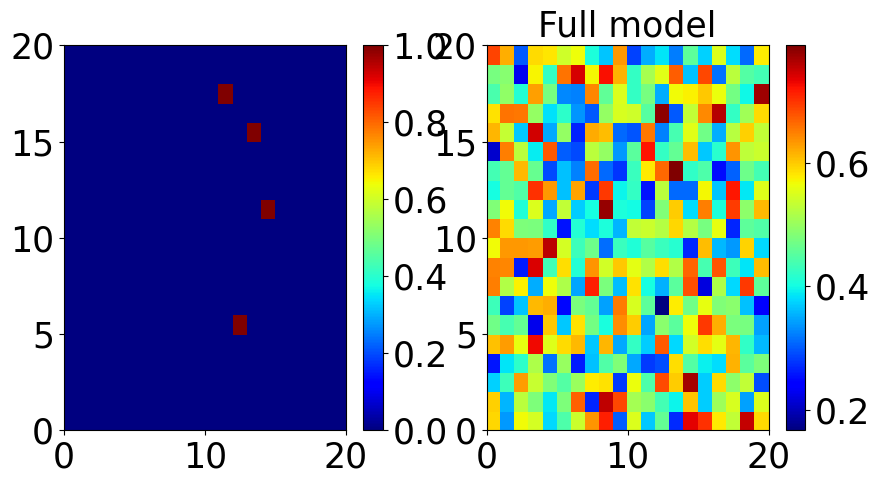

epoch: 0, train loss: 31.360061585903168, L1 loss: -1, val loss: 0.6225287914276123, max avg inners: 0.088202945211271, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 6.019355211406946, L1 loss: -1, val loss: 0.042625151574611664, max avg inners: 0.04978297443107845, GELMA loss: -1.1300802297658759, num indices: 0
epoch: 2, train loss: 1.2304070480167866, L1 loss: -1, val loss: 0.037271443754434586, max avg inners: 0.051395999984843586, GELMA loss: -0.37783783966629786, num indices: 0
epoch: 3, train loss: 1.1892042011022568, L1 loss: -1, val loss: 0.0370788611471653, max avg inners: 0.051474057586320975, GELMA loss: 0.004444256556380512, num indices: 0
epoch: 4, train loss: 1.190959144383669, L1 loss: -1, val loss: 0.03715066984295845, max avg inners: 0.05126737047917398, GELMA loss: -0.051304110635813124, num indices: 0
epoch: 5, train loss: 1.1893693879246712, L1 loss: -1, val loss: 0.037218447774648666, max avg inners: 0.051057896832296015, GELMA loss: -0.48687342635102854, n

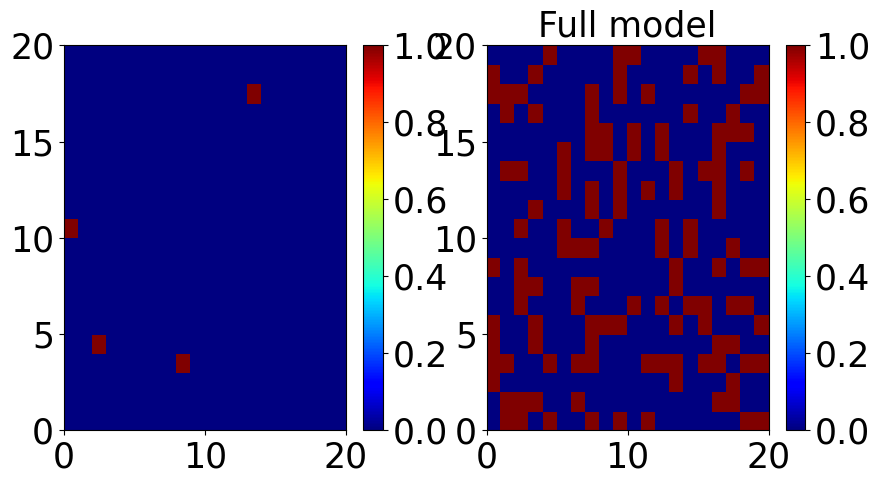

epoch: 100, train loss: 1.1894501149654388, L1 loss: -1, val loss: 0.037118200212717056, max avg inners: 0.05806679669952291, GELMA loss: -0.1771102085223501, num indices: 0
epoch: 101, train loss: 1.1901101432740688, L1 loss: -1, val loss: 0.0371270515024662, max avg inners: 0.05802313633653479, GELMA loss: -0.2255747735513912, num indices: 0
epoch: 102, train loss: 1.1875134818255901, L1 loss: -1, val loss: 0.03720128908753395, max avg inners: 0.05802345307357501, GELMA loss: -0.6888321272395818, num indices: 0
epoch: 103, train loss: 1.1882929913699627, L1 loss: -1, val loss: 0.0371425598859787, max avg inners: 0.058334837866065685, GELMA loss: 0.8248300431848378, num indices: 0
epoch: 104, train loss: 1.1890468373894691, L1 loss: -1, val loss: 0.03710441663861275, max avg inners: 0.05832984244556533, GELMA loss: 0.30773461362467375, num indices: 0
epoch: 105, train loss: 1.1889795176684856, L1 loss: -1, val loss: 0.03735737130045891, max avg inners: 0.05831376368265265, GELMA loss:

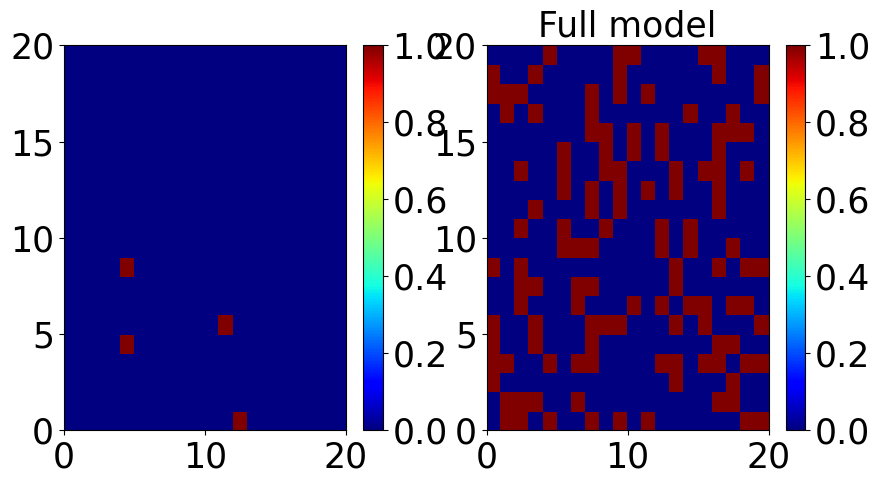

epoch: 200, train loss: 1.1836881376802921, L1 loss: -1, val loss: 0.03695768117904663, max avg inners: 0.058222104705085834, GELMA loss: 0.7622936006890527, num indices: 0
epoch: 201, train loss: 1.1839374676346779, L1 loss: -1, val loss: 0.03697037696838379, max avg inners: 0.05768588533706774, GELMA loss: -0.1926810696079381, num indices: 0
epoch: 202, train loss: 1.1836929768323898, L1 loss: -1, val loss: 0.03696867823600769, max avg inners: 0.05680708134007925, GELMA loss: 0.03980131718531602, num indices: 0
epoch: 203, train loss: 1.1834621913731098, L1 loss: -1, val loss: 0.03697245195508003, max avg inners: 0.057937931894571776, GELMA loss: -0.25652098993042904, num indices: 0
epoch: 204, train loss: 1.1837707944214344, L1 loss: -1, val loss: 0.0369601845741272, max avg inners: 0.05771978138131824, GELMA loss: 0.022632181028875518, num indices: 0
epoch: 205, train loss: 1.1839696057140827, L1 loss: -1, val loss: 0.03695530816912651, max avg inners: 0.05767511913878364, GELMA lo

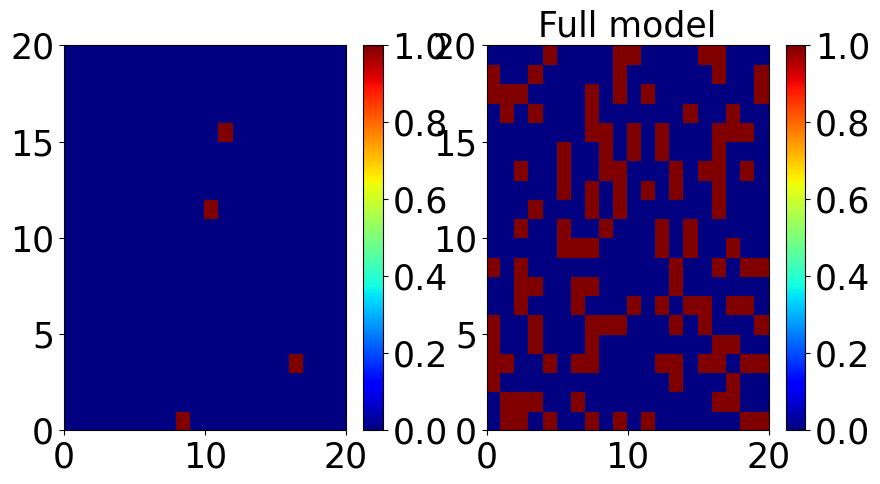

epoch: 300, train loss: 1.183004293590784, L1 loss: -1, val loss: 0.036931272596120834, max avg inners: 0.05069184607225462, GELMA loss: 0.3898276704440213, num indices: 0
epoch: 301, train loss: 1.1829983219504356, L1 loss: -1, val loss: 0.03693826496601105, max avg inners: 0.05051206852698074, GELMA loss: 0.24882738967051823, num indices: 0
epoch: 302, train loss: 1.1828321404755116, L1 loss: -1, val loss: 0.036919258534908295, max avg inners: 0.05044719574642281, GELMA loss: 0.10836617257604866, num indices: 0
epoch: 303, train loss: 1.1829562559723854, L1 loss: -1, val loss: 0.03693447634577751, max avg inners: 0.05023104359467406, GELMA loss: 0.8262377590036152, num indices: 0
epoch: 304, train loss: 1.1826000101864338, L1 loss: -1, val loss: 0.03692388907074928, max avg inners: 0.04914731407795299, GELMA loss: 0.3922861306338677, num indices: 0
epoch: 305, train loss: 1.1829408258199692, L1 loss: -1, val loss: 0.03696056827902794, max avg inners: 0.05123409005650161, GELMA loss: 

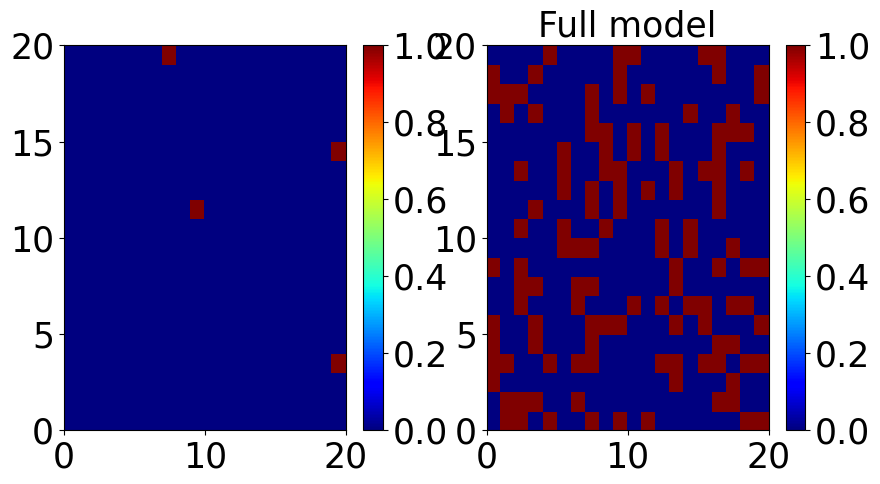

epoch: 400, train loss: 1.1820890419185162, L1 loss: -1, val loss: 0.036910392343997955, max avg inners: 0.06461968057363976, GELMA loss: -0.0771341752215411, num indices: 0
epoch: 401, train loss: 1.1822628304362297, L1 loss: -1, val loss: 0.036888349801301956, max avg inners: 0.06477122647138839, GELMA loss: 0.3453459734469781, num indices: 0
epoch: 402, train loss: 1.1820808053016663, L1 loss: -1, val loss: 0.03689730167388916, max avg inners: 0.06461310347057231, GELMA loss: -0.5547629053152239, num indices: 0
epoch: 403, train loss: 1.182202123105526, L1 loss: -1, val loss: 0.03690740093588829, max avg inners: 0.06503374303560926, GELMA loss: -0.3360613541445481, num indices: 0
epoch: 404, train loss: 1.1825169809162617, L1 loss: -1, val loss: 0.03689996153116226, max avg inners: 0.0707950262452415, GELMA loss: -0.5782658990796034, num indices: 0
epoch: 405, train loss: 1.1820478327572346, L1 loss: -1, val loss: 0.036893781274557114, max avg inners: 0.07010338705873091, GELMA loss

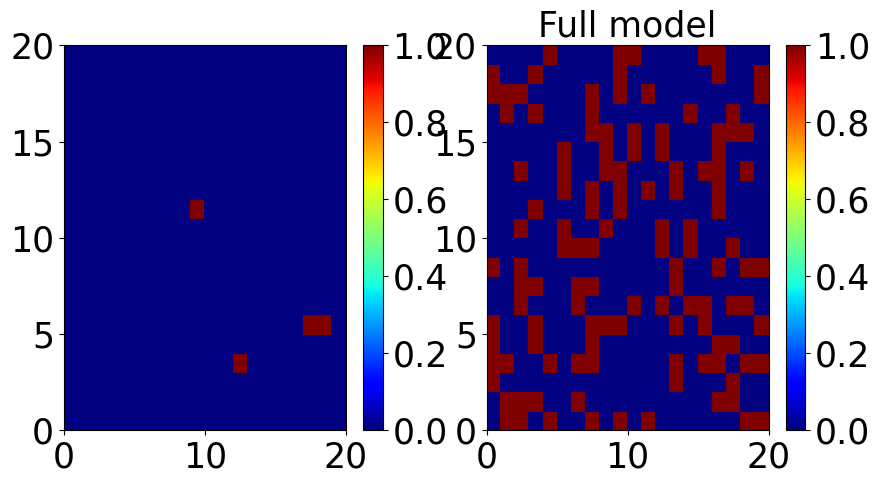

epoch: 500, train loss: 1.1816235408186913, L1 loss: -1, val loss: 0.03689130023121834, max avg inners: 0.07885791017594573, GELMA loss: -0.2699319831749676, num indices: 0
epoch: 501, train loss: 1.181515634059906, L1 loss: -1, val loss: 0.03689228743314743, max avg inners: 0.07829055496136944, GELMA loss: -0.6155886059553513, num indices: 0
epoch: 502, train loss: 1.1815915927290916, L1 loss: -1, val loss: 0.036887846887111664, max avg inners: 0.07837900671900727, GELMA loss: -0.13645921802926453, num indices: 0
epoch: 503, train loss: 1.1815595962107182, L1 loss: -1, val loss: 0.03688832372426987, max avg inners: 0.07854373050690282, GELMA loss: -0.49104008729769083, num indices: 0
epoch: 504, train loss: 1.1817022524774075, L1 loss: -1, val loss: 0.03689385578036308, max avg inners: 0.07878384910438269, GELMA loss: 0.44290828710291247, num indices: 0
epoch: 505, train loss: 1.1819764524698257, L1 loss: -1, val loss: 0.03688916191458702, max avg inners: 0.07872685877544212, GELMA lo

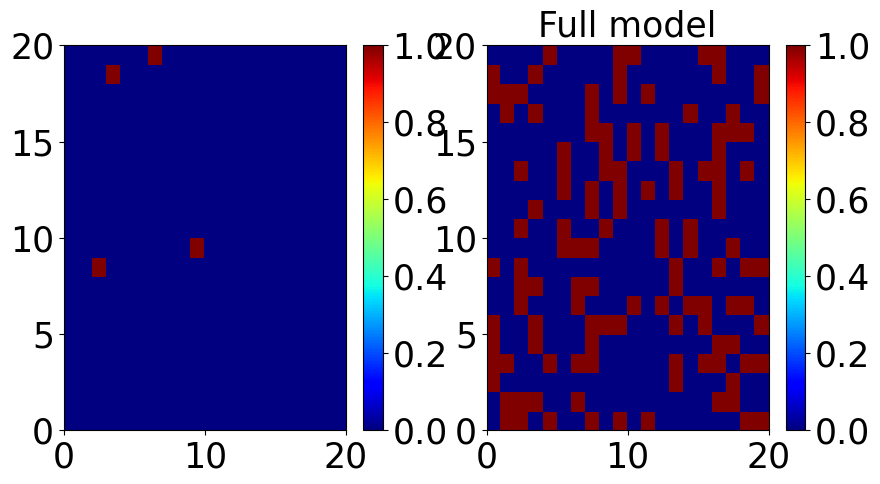

epoch: 600, train loss: 1.1814346611499786, L1 loss: -1, val loss: 0.03688863664865494, max avg inners: 0.07913911479670097, GELMA loss: 0.18949699334987039, num indices: 0
epoch: 601, train loss: 1.1813986599445343, L1 loss: -1, val loss: 0.03688690438866615, max avg inners: 0.07641395069465391, GELMA loss: 0.5946842033940295, num indices: 0
epoch: 602, train loss: 1.18137177079916, L1 loss: -1, val loss: 0.03688337281346321, max avg inners: 0.07716166150384532, GELMA loss: 0.19136725533229768, num indices: 0
epoch: 603, train loss: 1.181546125560999, L1 loss: -1, val loss: 0.03688005357980728, max avg inners: 0.07801642160035144, GELMA loss: -0.009543003228831356, num indices: 0
epoch: 604, train loss: 1.181092619895935, L1 loss: -1, val loss: 0.03688228502869606, max avg inners: 0.07762474027650608, GELMA loss: 0.4225013575794251, num indices: 0
epoch: 605, train loss: 1.1816147081553936, L1 loss: -1, val loss: 0.03689437359571457, max avg inners: 0.07591495925010104, GELMA loss: 0.

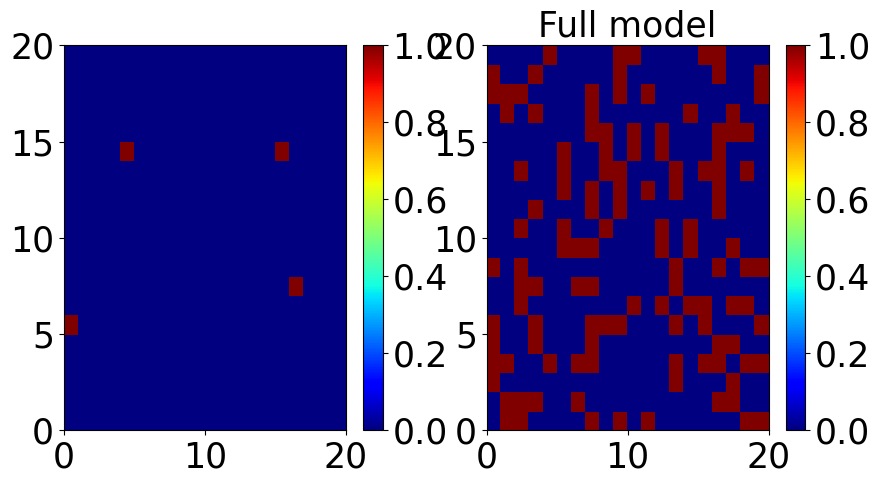

epoch: 700, train loss: 1.1811582930386066, L1 loss: -1, val loss: 0.036885034292936325, max avg inners: 0.08031525295710334, GELMA loss: -0.3377241856991267, num indices: 0
epoch: 701, train loss: 1.181497685611248, L1 loss: -1, val loss: 0.03687867522239685, max avg inners: 0.07937745047256332, GELMA loss: -0.047882431709873226, num indices: 0
epoch: 702, train loss: 1.1812667362391949, L1 loss: -1, val loss: 0.03688213601708412, max avg inners: 0.08070192151489365, GELMA loss: 0.6904620303883359, num indices: 0
epoch: 703, train loss: 1.1811570264399052, L1 loss: -1, val loss: 0.036879412829875946, max avg inners: 0.0798498457683814, GELMA loss: 0.16571855505895564, num indices: 0
epoch: 704, train loss: 1.1813232600688934, L1 loss: -1, val loss: 0.036887384951114655, max avg inners: 0.07971464453211807, GELMA loss: 0.2974068203081409, num indices: 0
epoch: 705, train loss: 1.181124608963728, L1 loss: -1, val loss: 0.036889344453811646, max avg inners: 0.08036861612017415, GELMA los

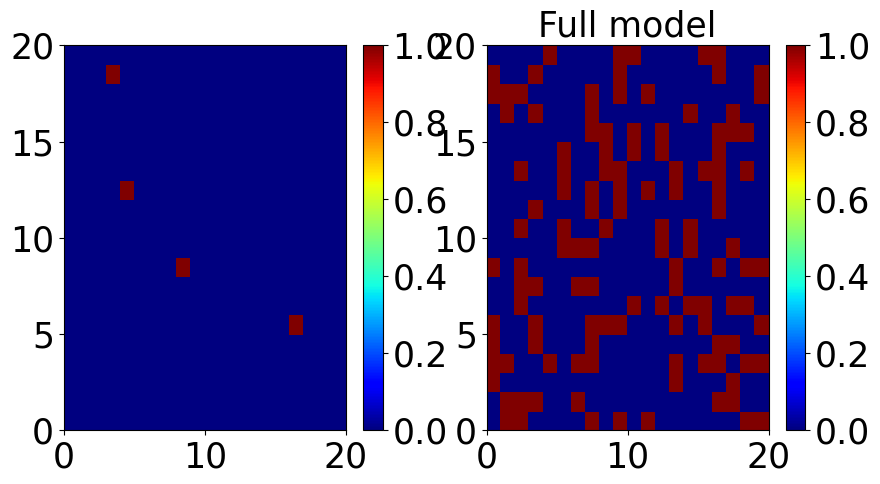

epoch: 800, train loss: 1.1811948493123055, L1 loss: -1, val loss: 0.03687308356165886, max avg inners: 0.081140937482636, GELMA loss: 0.17563164633846873, num indices: 0
epoch: 801, train loss: 1.181266400963068, L1 loss: -1, val loss: 0.03687310591340065, max avg inners: 0.08101095355382665, GELMA loss: -0.7999710026114633, num indices: 0
epoch: 802, train loss: 1.1809579320251942, L1 loss: -1, val loss: 0.03688792884349823, max avg inners: 0.08088700966297348, GELMA loss: 0.10957913699140663, num indices: 0
epoch: 803, train loss: 1.1810176521539688, L1 loss: -1, val loss: 0.036881670355796814, max avg inners: 0.08083370477289296, GELMA loss: -0.8088468491075043, num indices: 0
epoch: 804, train loss: 1.1813530549407005, L1 loss: -1, val loss: 0.036880724132061005, max avg inners: 0.08104101464205145, GELMA loss: -0.43677971256195197, num indices: 0
epoch: 805, train loss: 1.181263044476509, L1 loss: -1, val loss: 0.03687974065542221, max avg inners: 0.08081294326150261, GELMA loss:

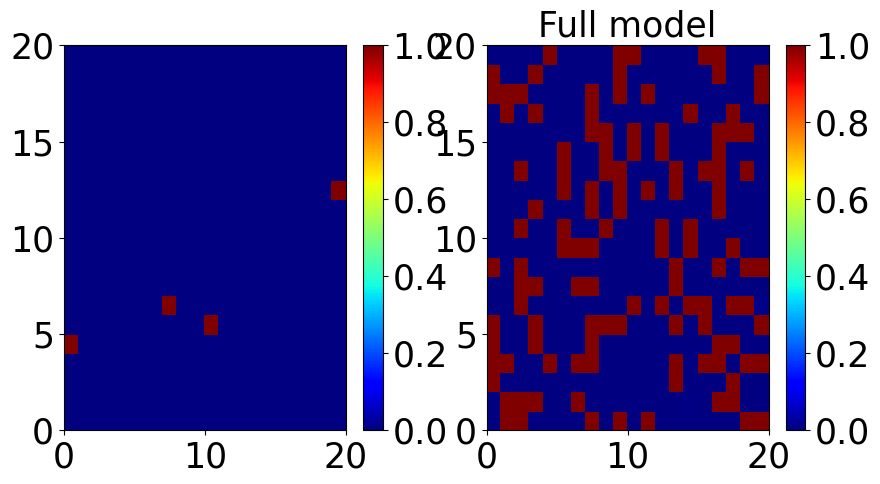

epoch: 900, train loss: 1.181162465363741, L1 loss: -1, val loss: 0.036876335740089417, max avg inners: 0.08080237653403197, GELMA loss: -1.095057111462805, num indices: 0
epoch: 901, train loss: 1.1810978129506111, L1 loss: -1, val loss: 0.03687494620680809, max avg inners: 0.0808772992789489, GELMA loss: -0.08864078032030084, num indices: 0
epoch: 902, train loss: 1.1810978464782238, L1 loss: -1, val loss: 0.03687620908021927, max avg inners: 0.08054035493408804, GELMA loss: -0.0019377171138149232, num indices: 0
epoch: 903, train loss: 1.1812032535672188, L1 loss: -1, val loss: 0.03687213733792305, max avg inners: 0.08063879980521341, GELMA loss: 0.5786589223671293, num indices: 0
epoch: 904, train loss: 1.1812079660594463, L1 loss: -1, val loss: 0.0368790477514267, max avg inners: 0.08059369139490836, GELMA loss: 0.23736568393540788, num indices: 0
epoch: 905, train loss: 1.18129064142704, L1 loss: -1, val loss: 0.03687872365117073, max avg inners: 0.08173196139273166, GELMA loss: 

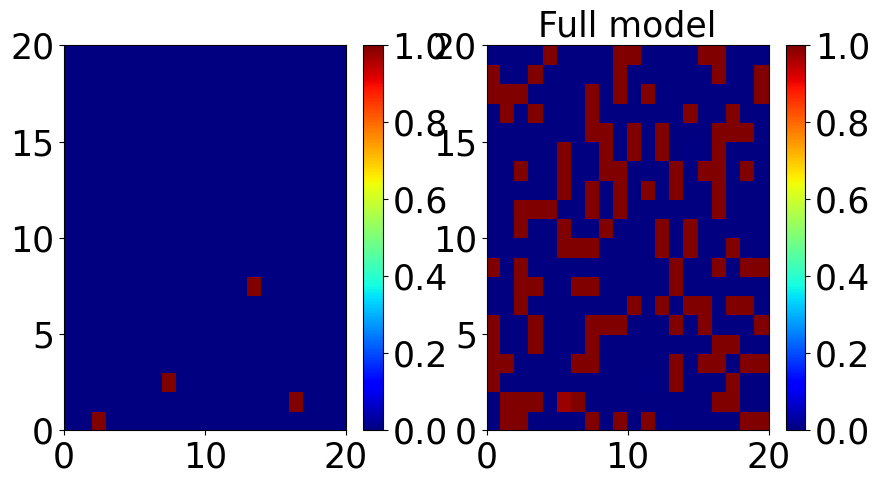

epoch: 1000, train loss: 1.1808820813894272, L1 loss: -1, val loss: 0.036879781633615494, max avg inners: 0.08119732360557608, GELMA loss: -0.05217064850191142, num indices: 0
epoch: 1001, train loss: 1.1812266632914543, L1 loss: -1, val loss: 0.03687916696071625, max avg inners: 0.08123696790557579, GELMA loss: -0.34525769673200646, num indices: 0
epoch: 1002, train loss: 1.1808782517910004, L1 loss: -1, val loss: 0.036875445395708084, max avg inners: 0.08109751005339551, GELMA loss: 0.3477778050385452, num indices: 0
epoch: 1003, train loss: 1.1812881454825401, L1 loss: -1, val loss: 0.03688088804483414, max avg inners: 0.08091677745513902, GELMA loss: 0.31802098173612997, num indices: 0
epoch: 1004, train loss: 1.1812796294689178, L1 loss: -1, val loss: 0.03687392547726631, max avg inners: 0.08097604447559949, GELMA loss: 0.6977794421405473, num indices: 0
epoch: 1005, train loss: 1.1811362020671368, L1 loss: -1, val loss: 0.036878325045108795, max avg inners: 0.08119766165897652, G

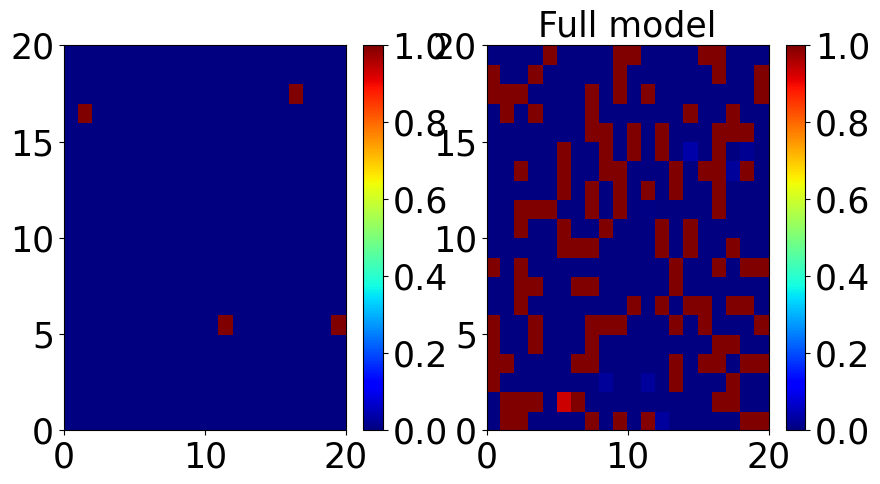

epoch: 1100, train loss: 1.1809547953307629, L1 loss: -1, val loss: 0.03687853366136551, max avg inners: 0.08090063527224016, GELMA loss: 0.6745522105400583, num indices: 0
epoch: 1101, train loss: 1.180994912981987, L1 loss: -1, val loss: 0.03687779977917671, max avg inners: 0.08100483728333463, GELMA loss: -0.21858063721745521, num indices: 0
epoch: 1102, train loss: 1.1810280345380306, L1 loss: -1, val loss: 0.03687616437673569, max avg inners: 0.08124741075528505, GELMA loss: 0.614291057359276, num indices: 0
epoch: 1103, train loss: 1.18134056776762, L1 loss: -1, val loss: 0.036884576082229614, max avg inners: 0.08078696184563722, GELMA loss: 0.3910559211570992, num indices: 0
epoch: 1104, train loss: 1.1808812320232391, L1 loss: -1, val loss: 0.03687581792473793, max avg inners: 0.08108973946978783, GELMA loss: 0.347418821887587, num indices: 0
epoch: 1105, train loss: 1.1808260902762413, L1 loss: -1, val loss: 0.03687028959393501, max avg inners: 0.08147390680210291, GELMA loss:

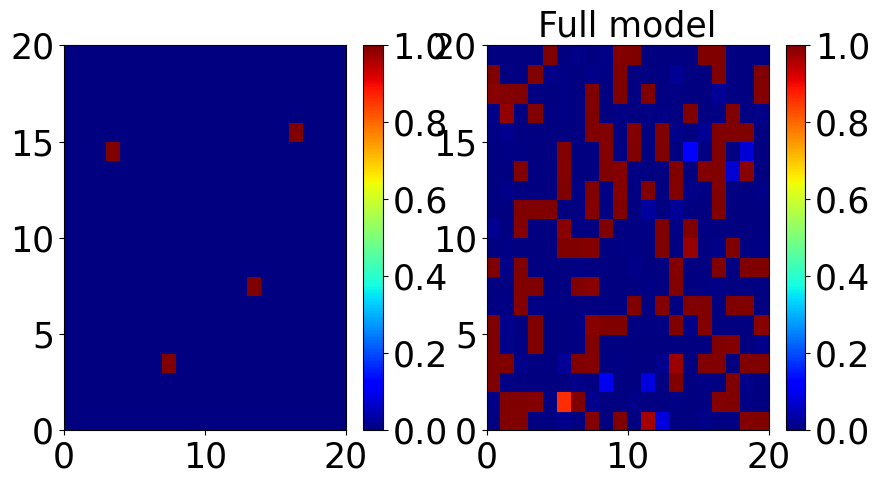

epoch: 1200, train loss: 1.1808697320520878, L1 loss: -1, val loss: 0.03687446936964989, max avg inners: 0.08145989948840807, GELMA loss: 0.303242347919131, num indices: 0
epoch: 1201, train loss: 1.181085016578436, L1 loss: -1, val loss: 0.036876264959573746, max avg inners: 0.08122327636456834, GELMA loss: 0.5758536551249416, num indices: 0
epoch: 1202, train loss: 1.1809437647461891, L1 loss: -1, val loss: 0.03687216714024544, max avg inners: 0.08125191656920835, GELMA loss: 1.0115369100064524, num indices: 0
epoch: 1203, train loss: 1.180975191295147, L1 loss: -1, val loss: 0.0368746854364872, max avg inners: 0.08138483650471284, GELMA loss: 0.47101839894652653, num indices: 0
epoch: 1204, train loss: 1.1810773313045502, L1 loss: -1, val loss: 0.036872584372758865, max avg inners: 0.08141857566747789, GELMA loss: -0.06734351990757566, num indices: 0
epoch: 1205, train loss: 1.181023970246315, L1 loss: -1, val loss: 0.036872752010822296, max avg inners: 0.0813459012103574, GELMA los

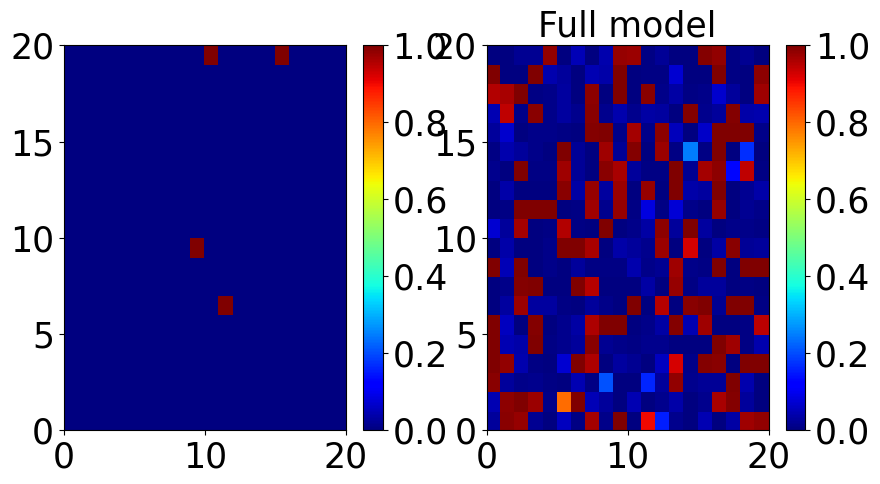

epoch: 1300, train loss: 1.1809607855975628, L1 loss: -1, val loss: 0.03687514364719391, max avg inners: 0.08107236200224471, GELMA loss: -0.9463513719681296, num indices: 0
epoch: 1301, train loss: 1.1808939054608345, L1 loss: -1, val loss: 0.036871958523988724, max avg inners: 0.08132300946801346, GELMA loss: -0.5080998073114252, num indices: 0
epoch: 1302, train loss: 1.1808956451714039, L1 loss: -1, val loss: 0.03687768056988716, max avg inners: 0.08122413321897845, GELMA loss: 0.19466455607261166, num indices: 0
epoch: 1303, train loss: 1.1808445416390896, L1 loss: -1, val loss: 0.03687460720539093, max avg inners: 0.08114860438977559, GELMA loss: -0.41580508567534696, num indices: 0
epoch: 1304, train loss: 1.1810012347996235, L1 loss: -1, val loss: 0.0368720218539238, max avg inners: 0.08121280498891932, GELMA loss: -0.3789615612197287, num indices: 0
epoch: 1305, train loss: 1.1812657043337822, L1 loss: -1, val loss: 0.036880407482385635, max avg inners: 0.08124385735294404, GE

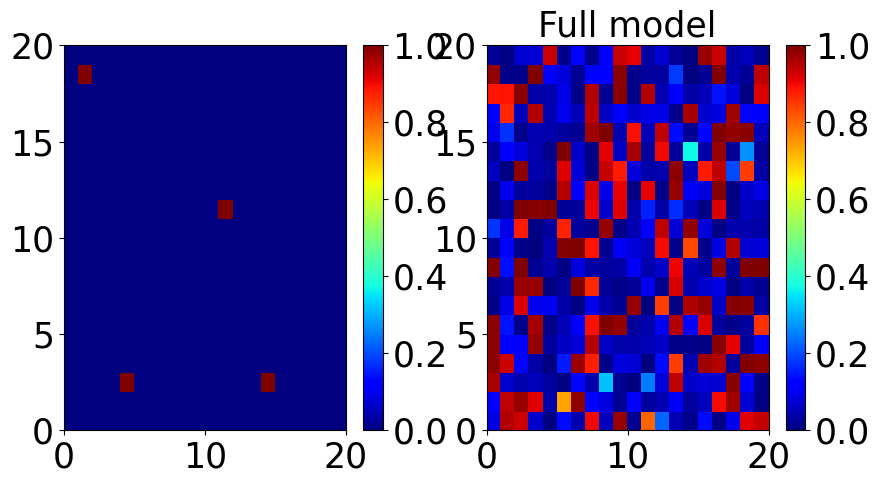

epoch: 1400, train loss: 1.181184433400631, L1 loss: -1, val loss: 0.03687210753560066, max avg inners: 0.08131430851162177, GELMA loss: 0.5771485567430565, num indices: 0
epoch: 1401, train loss: 1.1810154765844345, L1 loss: -1, val loss: 0.036871276795864105, max avg inners: 0.08136100087177293, GELMA loss: -0.6756061312846795, num indices: 0
epoch: 1402, train loss: 1.1810391657054424, L1 loss: -1, val loss: 0.03687276691198349, max avg inners: 0.0814063650753398, GELMA loss: 0.3733180983295285, num indices: 0
epoch: 1403, train loss: 1.1809872351586819, L1 loss: -1, val loss: 0.03687422350049019, max avg inners: 0.08115665738373008, GELMA loss: -0.12844358643071946, num indices: 0
epoch: 1404, train loss: 1.1812465004622936, L1 loss: -1, val loss: 0.03687397763133049, max avg inners: 0.08136743949109575, GELMA loss: 0.3400790696413917, num indices: 0
epoch: 1405, train loss: 1.1809703707695007, L1 loss: -1, val loss: 0.036872535943984985, max avg inners: 0.0812840162870338, GELMA l

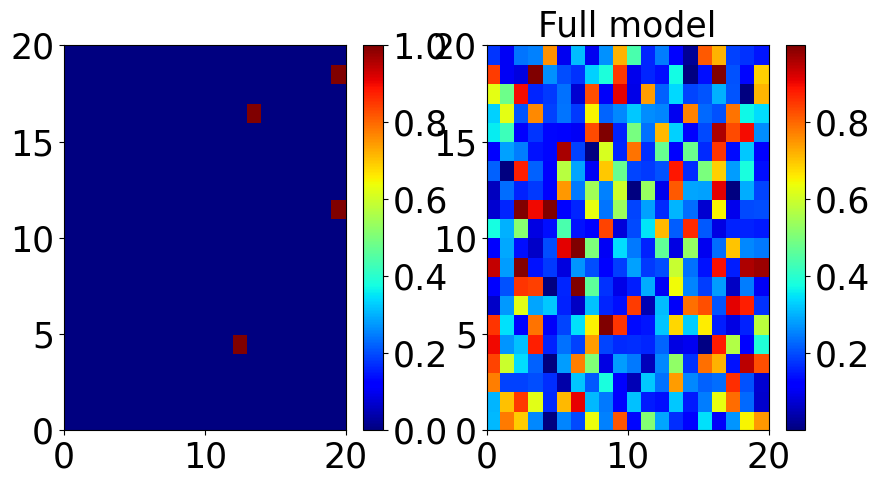

epoch: 1500, train loss: 1.1808633096516132, L1 loss: -1, val loss: 0.03687448427081108, max avg inners: 0.0811452919504902, GELMA loss: 0.4017074663479404, num indices: 0
epoch: 1501, train loss: 1.180836420506239, L1 loss: -1, val loss: 0.03687126934528351, max avg inners: 0.08139184386971848, GELMA loss: 0.13339707481093202, num indices: 0
epoch: 1502, train loss: 1.1812834963202477, L1 loss: -1, val loss: 0.03687048703432083, max avg inners: 0.08147392889099452, GELMA loss: -0.23197871320954813, num indices: 0
epoch: 1503, train loss: 1.1812854371964931, L1 loss: -1, val loss: 0.03687574714422226, max avg inners: 0.08115115950852939, GELMA loss: -0.14704534315982015, num indices: 0
epoch: 1504, train loss: 1.1812510155141354, L1 loss: -1, val loss: 0.03686697781085968, max avg inners: 0.08119897805422369, GELMA loss: -0.5215600608158025, num indices: 0
epoch: 1505, train loss: 1.1809295266866684, L1 loss: -1, val loss: 0.03687068819999695, max avg inners: 0.08140384833001629, GELMA

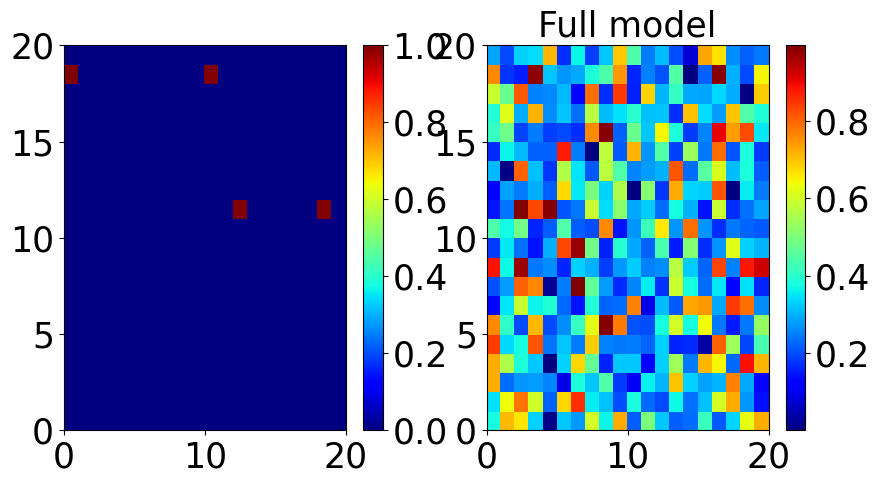

epoch: 1600, train loss: 1.1808641478419304, L1 loss: -1, val loss: 0.036874476820230484, max avg inners: 0.08113951270295598, GELMA loss: 0.8160031128415006, num indices: 0
epoch: 1601, train loss: 1.1808415278792381, L1 loss: -1, val loss: 0.036871712654829025, max avg inners: 0.08137195582799737, GELMA loss: -0.11767868440873397, num indices: 0
epoch: 1602, train loss: 1.1811557486653328, L1 loss: -1, val loss: 0.03687141463160515, max avg inners: 0.08128147501209901, GELMA loss: 0.01099978574718422, num indices: 0
epoch: 1603, train loss: 1.1810344941914082, L1 loss: -1, val loss: 0.03687577322125435, max avg inners: 0.08114708950562186, GELMA loss: -0.053123239621494844, num indices: 0
epoch: 1604, train loss: 1.1808472350239754, L1 loss: -1, val loss: 0.0368756465613842, max avg inners: 0.08130518706323359, GELMA loss: 0.26461192805194095, num indices: 0
epoch: 1605, train loss: 1.1809677295386791, L1 loss: -1, val loss: 0.036871422082185745, max avg inners: 0.08139252256146409, 

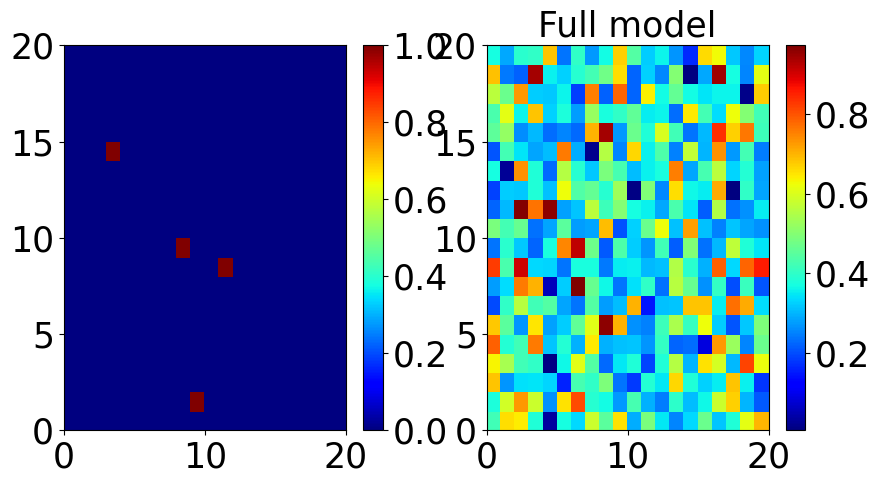

epoch: 1700, train loss: 1.180841352790594, L1 loss: -1, val loss: 0.03687397390604019, max avg inners: 0.0813045575919109, GELMA loss: 0.18855683971797732, num indices: 0
epoch: 1701, train loss: 1.1810158789157867, L1 loss: -1, val loss: 0.036871153861284256, max avg inners: 0.08125202051348433, GELMA loss: -0.2807739254904838, num indices: 0
epoch: 1702, train loss: 1.1811452843248844, L1 loss: -1, val loss: 0.036863669753074646, max avg inners: 0.08158307068840348, GELMA loss: 0.03756491197654825, num indices: 0
epoch: 1703, train loss: 1.1809102818369865, L1 loss: -1, val loss: 0.036878034472465515, max avg inners: 0.08096440958394338, GELMA loss: -0.2067652555221968, num indices: 0
epoch: 1704, train loss: 1.1811159141361713, L1 loss: -1, val loss: 0.036873649805784225, max avg inners: 0.08127327191013739, GELMA loss: -0.1613297464869861, num indices: 0
epoch: 1705, train loss: 1.1809871047735214, L1 loss: -1, val loss: 0.03686627000570297, max avg inners: 0.08147359485141134, GE

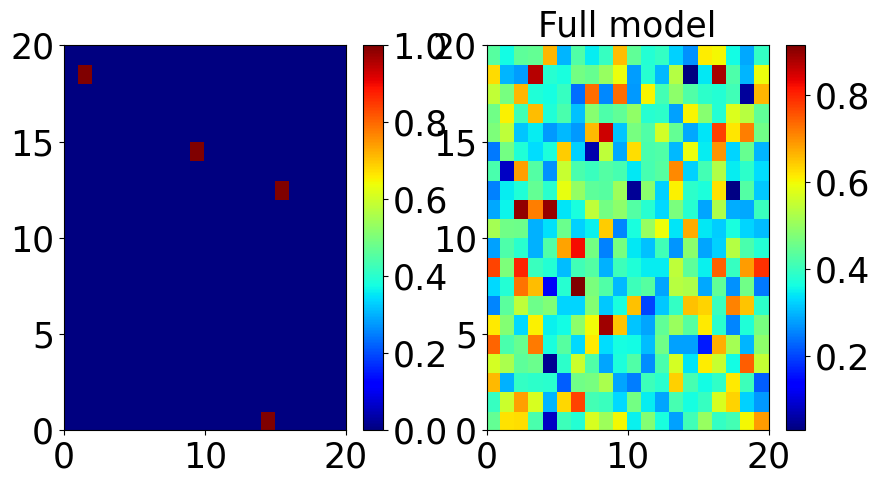

epoch: 1800, train loss: 1.1810966469347477, L1 loss: -1, val loss: 0.03687664121389389, max avg inners: 0.08134839462584086, GELMA loss: 0.13384720664794866, num indices: 0
epoch: 1801, train loss: 1.1810555420815945, L1 loss: -1, val loss: 0.03687383234500885, max avg inners: 0.08151610970038124, GELMA loss: 0.08783298220386115, num indices: 0
epoch: 1802, train loss: 1.1808413229882717, L1 loss: -1, val loss: 0.03686989098787308, max avg inners: 0.08149658992034407, GELMA loss: 0.7874422206512697, num indices: 0
epoch: 1803, train loss: 1.1809357330203056, L1 loss: -1, val loss: 0.03687572479248047, max avg inners: 0.08149564407766142, GELMA loss: 0.4813904232647738, num indices: 0
epoch: 1804, train loss: 1.180912684649229, L1 loss: -1, val loss: 0.03687310963869095, max avg inners: 0.08094193915769822, GELMA loss: -0.06980066322588688, num indices: 0
epoch: 1805, train loss: 1.180977638810873, L1 loss: -1, val loss: 0.036867834627628326, max avg inners: 0.08139803996598688, GELMA 

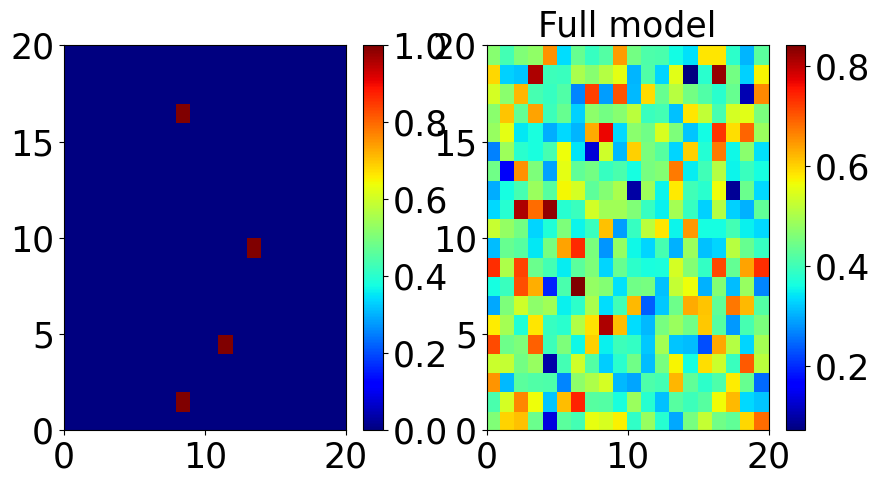

epoch: 1900, train loss: 1.1809682585299015, L1 loss: -1, val loss: 0.036873042583465576, max avg inners: 0.08124565378692016, GELMA loss: 0.779922262145546, num indices: 0
epoch: 1901, train loss: 1.1808557100594044, L1 loss: -1, val loss: 0.036875590682029724, max avg inners: 0.08124009694019067, GELMA loss: 0.45761007914972773, num indices: 0
epoch: 1902, train loss: 1.18094003200531, L1 loss: -1, val loss: 0.03687214106321335, max avg inners: 0.08155213075321312, GELMA loss: 0.3993832079406746, num indices: 0
epoch: 1903, train loss: 1.1808286644518375, L1 loss: -1, val loss: 0.03687116503715515, max avg inners: 0.08146630017460633, GELMA loss: 0.09162391786396719, num indices: 0
epoch: 1904, train loss: 1.181450180709362, L1 loss: -1, val loss: 0.03687237948179245, max avg inners: 0.08124295480346175, GELMA loss: -0.3721529780408006, num indices: 0
epoch: 1905, train loss: 1.1809669323265553, L1 loss: -1, val loss: 0.03686404973268509, max avg inners: 0.08149687183227415, GELMA lo

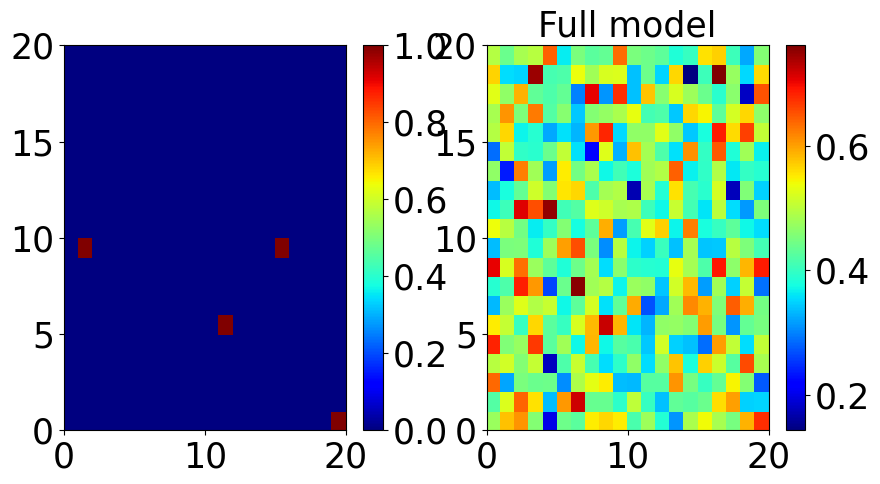

epoch: 2000, train loss: 1.1809522025287151, L1 loss: -1, val loss: 0.03687596321105957, max avg inners: 0.08112005575678649, GELMA loss: 0.21586534075613356, num indices: 0
epoch: 2001, train loss: 1.1809769347310066, L1 loss: -1, val loss: 0.03687119111418724, max avg inners: 0.08141260026861528, GELMA loss: -0.36240574640027173, num indices: 0
epoch: 2002, train loss: 1.1809113882482052, L1 loss: -1, val loss: 0.03687172010540962, max avg inners: 0.08130443320411303, GELMA loss: -0.4411247268835705, num indices: 0
epoch: 2003, train loss: 1.1807731240987778, L1 loss: -1, val loss: 0.036873191595077515, max avg inners: 0.08125585766908092, GELMA loss: 0.02547061490490428, num indices: 0
epoch: 2004, train loss: 1.1808978505432606, L1 loss: -1, val loss: 0.03686938062310219, max avg inners: 0.08127590829821407, GELMA loss: -0.0801229375933728, num indices: 0
epoch: 2005, train loss: 1.1807681918144226, L1 loss: -1, val loss: 0.036875169724226, max avg inners: 0.08136488191636987, GELM

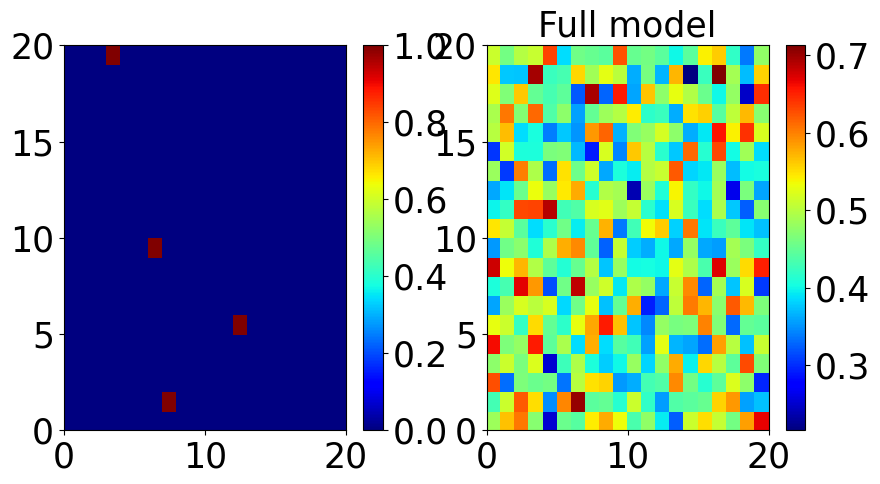

epoch: 2100, train loss: 1.1810435727238655, L1 loss: -1, val loss: 0.036874257028102875, max avg inners: 0.08134355905705813, GELMA loss: 0.2594014313466857, num indices: 0
epoch: 2101, train loss: 1.181092593818903, L1 loss: -1, val loss: 0.036873988807201385, max avg inners: 0.08115099372294907, GELMA loss: 0.2236717816864864, num indices: 0
epoch: 2102, train loss: 1.1808961778879166, L1 loss: -1, val loss: 0.0368712916970253, max avg inners: 0.08155804212450488, GELMA loss: 0.24958720469398496, num indices: 0
epoch: 2103, train loss: 1.1810047589242458, L1 loss: -1, val loss: 0.03687097132205963, max avg inners: 0.08142597970835011, GELMA loss: 0.7627493573542348, num indices: 0
epoch: 2104, train loss: 1.180749598890543, L1 loss: -1, val loss: 0.0368691012263298, max avg inners: 0.08121232653031844, GELMA loss: -0.3744308878639838, num indices: 0
epoch: 2105, train loss: 1.1808484829962254, L1 loss: -1, val loss: 0.03686349093914032, max avg inners: 0.08146916152064182, GELMA los

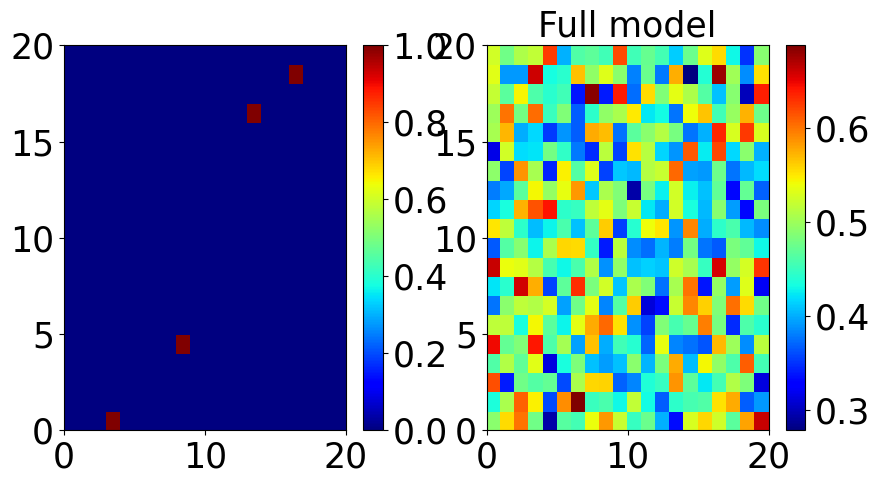

epoch: 2200, train loss: 1.1807193085551262, L1 loss: -1, val loss: 0.036873556673526764, max avg inners: 0.08118613021857769, GELMA loss: 0.6673362309832805, num indices: 0
epoch: 2201, train loss: 1.1807384490966797, L1 loss: -1, val loss: 0.03686605766415596, max avg inners: 0.08156228060192848, GELMA loss: -0.8209265447869755, num indices: 0
epoch: 2202, train loss: 1.1808135360479355, L1 loss: -1, val loss: 0.036867305636405945, max avg inners: 0.0815791583049271, GELMA loss: 0.41819885372384685, num indices: 0
epoch: 2203, train loss: 1.180907465517521, L1 loss: -1, val loss: 0.03687071055173874, max avg inners: 0.08162801703281303, GELMA loss: 0.029646857911782405, num indices: 0
epoch: 2204, train loss: 1.1808658577501774, L1 loss: -1, val loss: 0.036868222057819366, max avg inners: 0.0814729942661799, GELMA loss: 0.5350926297580517, num indices: 0
epoch: 2205, train loss: 1.1808675900101662, L1 loss: -1, val loss: 0.036869339644908905, max avg inners: 0.08131577662777036, GELM

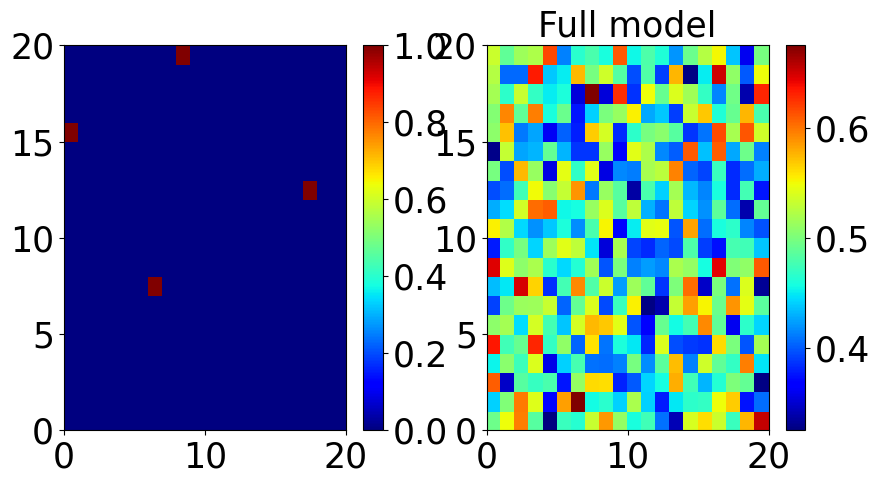

epoch: 2300, train loss: 1.1809968762099743, L1 loss: -1, val loss: 0.03687035292387009, max avg inners: 0.08153285036778044, GELMA loss: -0.9093353968984063, num indices: 0
epoch: 2301, train loss: 1.1809168681502342, L1 loss: -1, val loss: 0.03687127307057381, max avg inners: 0.08151579377269368, GELMA loss: -0.22992439361466044, num indices: 0
epoch: 2302, train loss: 1.1811255067586899, L1 loss: -1, val loss: 0.036871861666440964, max avg inners: 0.081388571561536, GELMA loss: 0.20424231494924064, num indices: 0
epoch: 2303, train loss: 1.1810144297778606, L1 loss: -1, val loss: 0.03686819598078728, max avg inners: 0.08107501879827395, GELMA loss: -0.12612419846290038, num indices: 0
epoch: 2304, train loss: 1.1807910948991776, L1 loss: -1, val loss: 0.03686932474374771, max avg inners: 0.08130958183163103, GELMA loss: 0.042381028818072895, num indices: 0
epoch: 2305, train loss: 1.1807870008051395, L1 loss: -1, val loss: 0.03687110170722008, max avg inners: 0.08141656953868508, GE

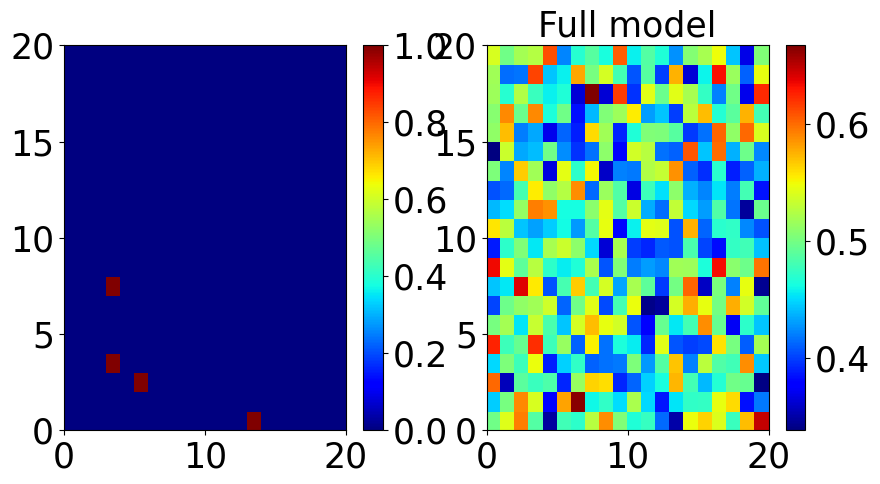

epoch: 2400, train loss: 1.1806818954646587, L1 loss: -1, val loss: 0.036867905408144, max avg inners: 0.08144658368624486, GELMA loss: -0.4024198475263609, num indices: 0
epoch: 2401, train loss: 1.18078176304698, L1 loss: -1, val loss: 0.03686939552426338, max avg inners: 0.08153653965695769, GELMA loss: -0.022131427392731842, num indices: 0
epoch: 2402, train loss: 1.180842813104391, L1 loss: -1, val loss: 0.036868829280138016, max avg inners: 0.08150493704403973, GELMA loss: -0.2219573208267947, num indices: 0
epoch: 2403, train loss: 1.1809424087405205, L1 loss: -1, val loss: 0.03686806559562683, max avg inners: 0.0815179139389019, GELMA loss: -0.06294123821778884, num indices: 0
epoch: 2404, train loss: 1.1810628399252892, L1 loss: -1, val loss: 0.03686761111021042, max avg inners: 0.08149375406956814, GELMA loss: 0.42010467785516903, num indices: 0
epoch: 2405, train loss: 1.1809264719486237, L1 loss: -1, val loss: 0.03686694800853729, max avg inners: 0.0814315501328543, GELMA l

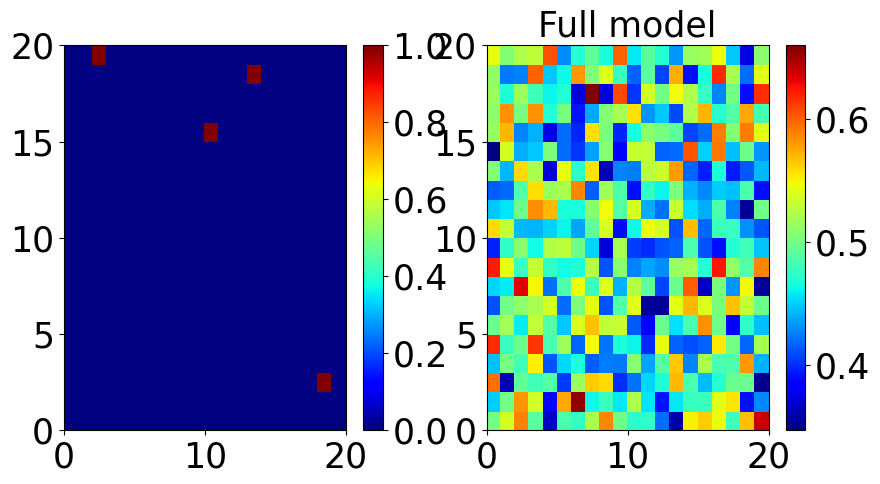

epoch: 2500, train loss: 1.1808279305696487, L1 loss: -1, val loss: 0.03687047213315964, max avg inners: 0.08145470823590129, GELMA loss: -0.151591766034428, num indices: 0
epoch: 2501, train loss: 1.180976741015911, L1 loss: -1, val loss: 0.03686853125691414, max avg inners: 0.08168904407331197, GELMA loss: -0.2584390166301476, num indices: 0
epoch: 2502, train loss: 1.18104600161314, L1 loss: -1, val loss: 0.03687266260385513, max avg inners: 0.0814995170406217, GELMA loss: -0.5888828217987255, num indices: 0
epoch: 2503, train loss: 1.1806389652192593, L1 loss: -1, val loss: 0.03687290474772453, max avg inners: 0.0812186160012859, GELMA loss: 0.22500337041912938, num indices: 0
epoch: 2504, train loss: 1.180908489972353, L1 loss: -1, val loss: 0.03686842694878578, max avg inners: 0.08123526791351984, GELMA loss: 0.3192390680538409, num indices: 0
epoch: 2505, train loss: 1.1810746416449547, L1 loss: -1, val loss: 0.036872755736112595, max avg inners: 0.08122855778802346, GELMA loss:

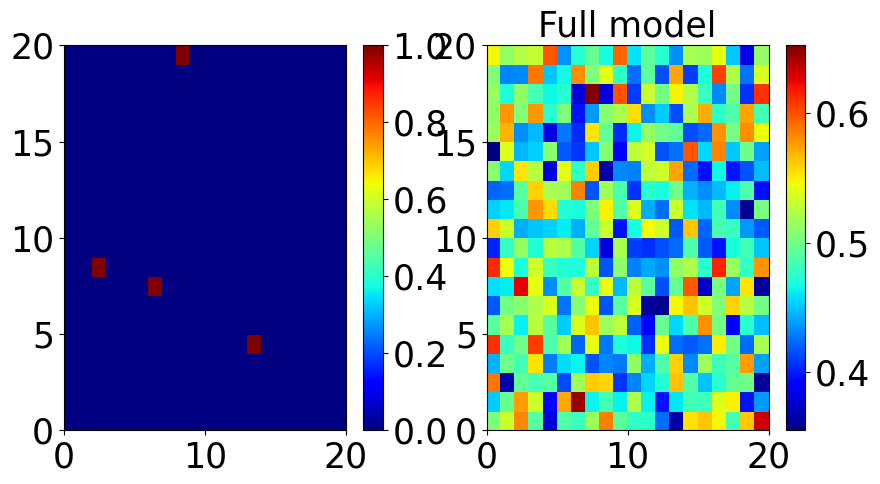

epoch: 2600, train loss: 1.1808455996215343, L1 loss: -1, val loss: 0.036867573857307434, max avg inners: 0.08113767985088999, GELMA loss: 0.11909496320121256, num indices: 0
epoch: 2601, train loss: 1.1808024272322655, L1 loss: -1, val loss: 0.03686763346195221, max avg inners: 0.08154242063217834, GELMA loss: 0.36692440247607744, num indices: 0
epoch: 2602, train loss: 1.1809924356639385, L1 loss: -1, val loss: 0.03686951845884323, max avg inners: 0.08154414864939785, GELMA loss: -0.33328223904460674, num indices: 0
epoch: 2603, train loss: 1.1808091178536415, L1 loss: -1, val loss: 0.03687640652060509, max avg inners: 0.08121549509207476, GELMA loss: 0.09796006841656417, num indices: 0
epoch: 2604, train loss: 1.1807184629142284, L1 loss: -1, val loss: 0.03686860203742981, max avg inners: 0.08137831461291732, GELMA loss: -0.3521723178480189, num indices: 0
epoch: 2605, train loss: 1.1809574626386166, L1 loss: -1, val loss: 0.03687041997909546, max avg inners: 0.08142980336149291, GE

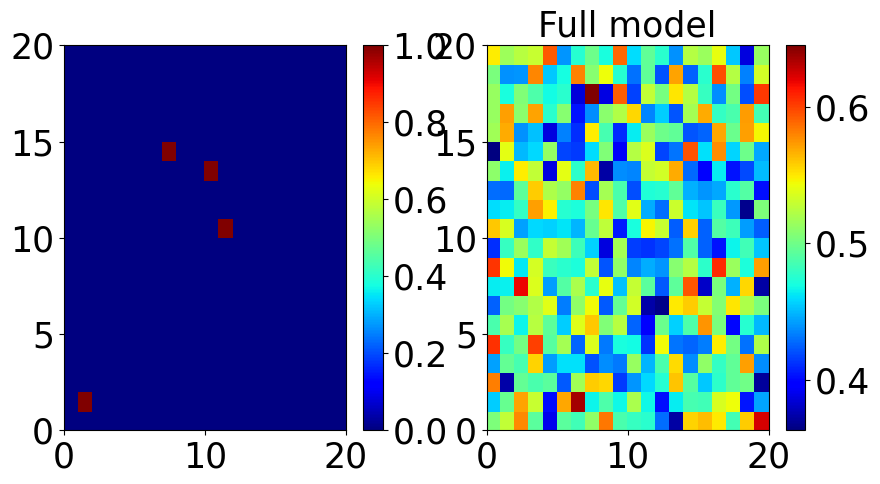

epoch: 2700, train loss: 1.1809991113841534, L1 loss: -1, val loss: 0.03686745464801788, max avg inners: 0.08126373209271472, GELMA loss: -0.5044013438263578, num indices: 0
epoch: 2701, train loss: 1.180952649563551, L1 loss: -1, val loss: 0.03686998039484024, max avg inners: 0.08132811860286314, GELMA loss: -0.6316641795634945, num indices: 0
epoch: 2702, train loss: 1.180956408381462, L1 loss: -1, val loss: 0.03687028959393501, max avg inners: 0.08156059624684647, GELMA loss: 0.6648968290347473, num indices: 0
epoch: 2703, train loss: 1.1807646416127682, L1 loss: -1, val loss: 0.03686916455626488, max avg inners: 0.08138794342091352, GELMA loss: -0.17024704465788335, num indices: 0
epoch: 2704, train loss: 1.180647511035204, L1 loss: -1, val loss: 0.03687209263443947, max avg inners: 0.08134325116743346, GELMA loss: -0.32501382105086546, num indices: 0
epoch: 2705, train loss: 1.1809395365417004, L1 loss: -1, val loss: 0.03687438368797302, max avg inners: 0.0813873208322996, GELMA l

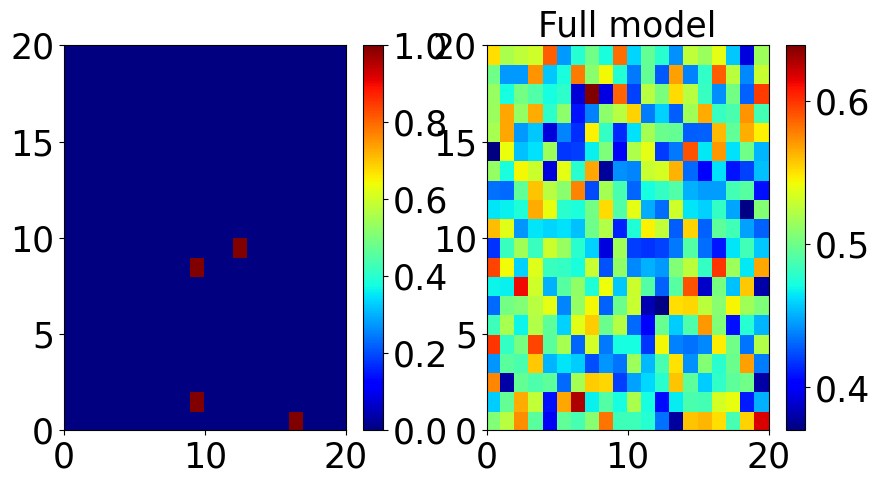

epoch: 2800, train loss: 1.180954895913601, L1 loss: -1, val loss: 0.036868300288915634, max avg inners: 0.081710487223315, GELMA loss: 0.10244741074310104, num indices: 0
epoch: 2801, train loss: 1.1809498891234398, L1 loss: -1, val loss: 0.03686923906207085, max avg inners: 0.08138307602471218, GELMA loss: 0.6077511689130848, num indices: 0
epoch: 2802, train loss: 1.1810131892561913, L1 loss: -1, val loss: 0.036867655813694, max avg inners: 0.08145760410362485, GELMA loss: -0.23533608711466816, num indices: 0
epoch: 2803, train loss: 1.1808991990983486, L1 loss: -1, val loss: 0.036869604140520096, max avg inners: 0.08141465617724786, GELMA loss: -0.36853617382580434, num indices: 0
epoch: 2804, train loss: 1.1806525737047195, L1 loss: -1, val loss: 0.03686656802892685, max avg inners: 0.08144214760211436, GELMA loss: -0.5600450027743017, num indices: 0
epoch: 2805, train loss: 1.1809002980589867, L1 loss: -1, val loss: 0.036868784576654434, max avg inners: 0.08146490325518346, GELMA

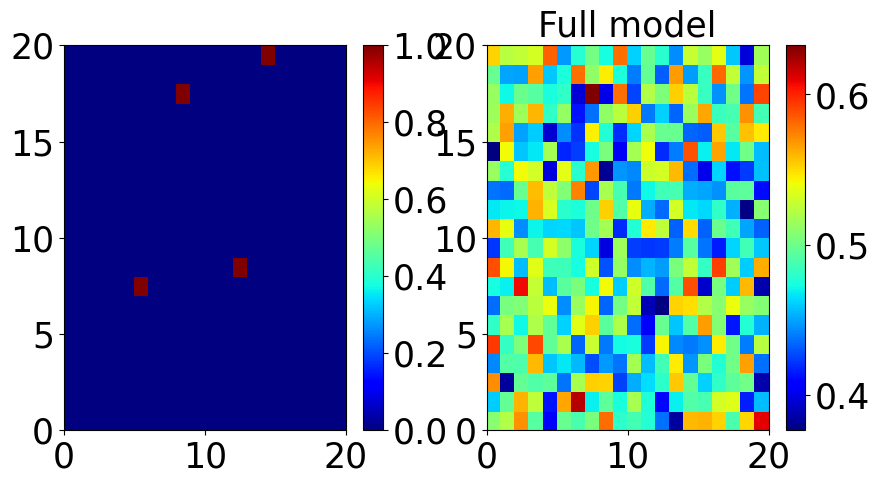

epoch: 2900, train loss: 1.180656224489212, L1 loss: -1, val loss: 0.03686465695500374, max avg inners: 0.08162932342879832, GELMA loss: 0.40915952986898574, num indices: 0
epoch: 2901, train loss: 1.1808807216584682, L1 loss: -1, val loss: 0.0368645116686821, max avg inners: 0.08175297306344008, GELMA loss: -0.07510995176606053, num indices: 0
epoch: 2902, train loss: 1.1806783080101013, L1 loss: -1, val loss: 0.03687332570552826, max avg inners: 0.08118375176189759, GELMA loss: 0.022010252050437724, num indices: 0
epoch: 2903, train loss: 1.1809132993221283, L1 loss: -1, val loss: 0.036866240203380585, max avg inners: 0.0816566802147724, GELMA loss: 0.023354883766979424, num indices: 0
epoch: 2904, train loss: 1.1807766631245613, L1 loss: -1, val loss: 0.036868270486593246, max avg inners: 0.08150119097904533, GELMA loss: -0.7284304940072467, num indices: 0
epoch: 2905, train loss: 1.1808478236198425, L1 loss: -1, val loss: 0.0368676483631134, max avg inners: 0.08158785787658564, GEL

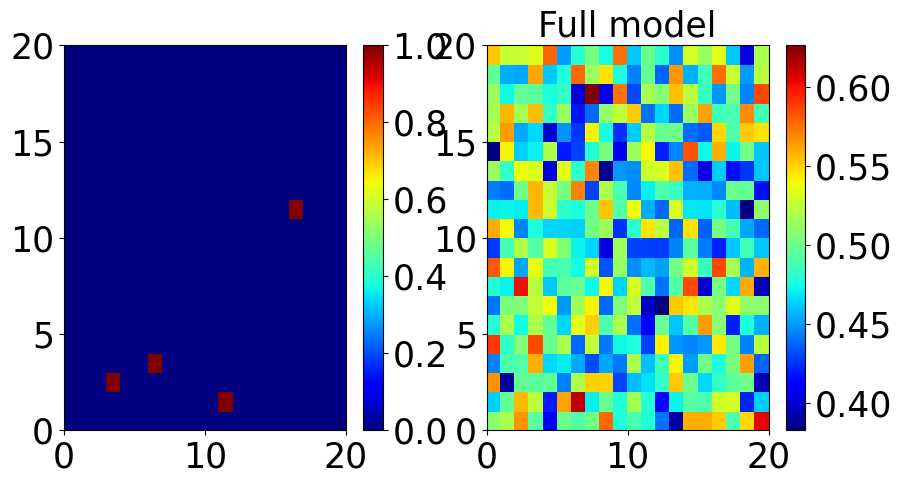

epoch: 3000, train loss: 1.1809610538184643, L1 loss: -1, val loss: 0.03687034547328949, max avg inners: 0.08118474743895286, GELMA loss: 0.16639125803775315, num indices: 0
epoch: 3001, train loss: 1.1810370348393917, L1 loss: -1, val loss: 0.03687076270580292, max avg inners: 0.08127588139193309, GELMA loss: -0.18416964580256345, num indices: 0
epoch: 3002, train loss: 1.1808822751045227, L1 loss: -1, val loss: 0.03687243536114693, max avg inners: 0.08143883039990314, GELMA loss: 0.32028981242490984, num indices: 0
epoch: 3003, train loss: 1.1807606294751167, L1 loss: -1, val loss: 0.03686416521668434, max avg inners: 0.08133258019062665, GELMA loss: -0.6523923992717874, num indices: 0
epoch: 3004, train loss: 1.180647648870945, L1 loss: -1, val loss: 0.03686908259987831, max avg inners: 0.08137466327081443, GELMA loss: -0.07543195001747027, num indices: 0
epoch: 3005, train loss: 1.1807293444871902, L1 loss: -1, val loss: 0.03686966747045517, max avg inners: 0.0812359103034501, GELM

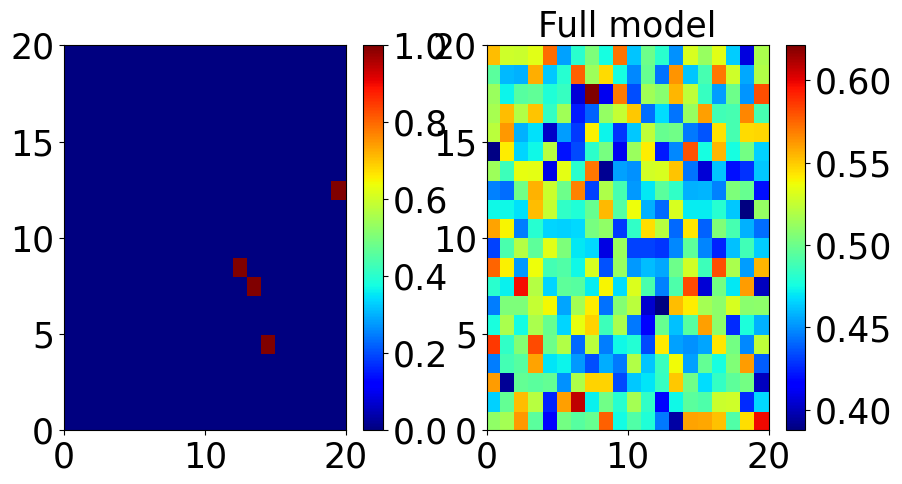

epoch: 3100, train loss: 1.1806897670030594, L1 loss: -1, val loss: 0.03687131777405739, max avg inners: 0.08151044915649068, GELMA loss: 0.4317672892174563, num indices: 0
epoch: 3101, train loss: 1.1806997992098331, L1 loss: -1, val loss: 0.03687272220849991, max avg inners: 0.08131449166698677, GELMA loss: 0.5659191233239511, num indices: 0
epoch: 3102, train loss: 1.1807333417236805, L1 loss: -1, val loss: 0.03686784952878952, max avg inners: 0.08122252951497134, GELMA loss: -0.9491702976165919, num indices: 0
epoch: 3103, train loss: 1.1809228621423244, L1 loss: -1, val loss: 0.036869876086711884, max avg inners: 0.08138018192397903, GELMA loss: -0.5127907287128788, num indices: 0
epoch: 3104, train loss: 1.1809519790112972, L1 loss: -1, val loss: 0.03686709702014923, max avg inners: 0.08151753830898334, GELMA loss: 0.4488511232004079, num indices: 0
epoch: 3105, train loss: 1.1808495372533798, L1 loss: -1, val loss: 0.03687398508191109, max avg inners: 0.08145821064874312, GELMA 

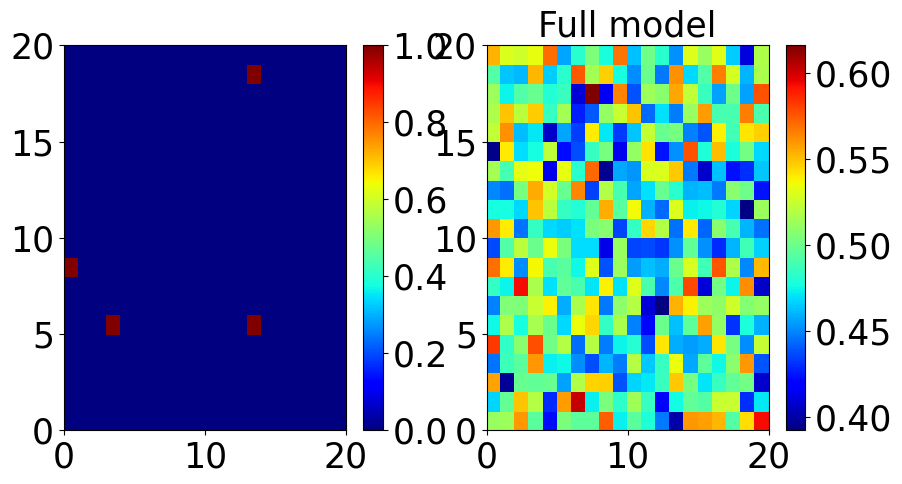

epoch: 3200, train loss: 1.1809996627271175, L1 loss: -1, val loss: 0.03686903044581413, max avg inners: 0.08128118652939217, GELMA loss: 0.530706216701136, num indices: 0
epoch: 3201, train loss: 1.180973831564188, L1 loss: -1, val loss: 0.03686700761318207, max avg inners: 0.08155026182402983, GELMA loss: 0.44313764774316117, num indices: 0
epoch: 3202, train loss: 1.1808261051774025, L1 loss: -1, val loss: 0.036868974566459656, max avg inners: 0.08135173345473737, GELMA loss: 0.0739114133805855, num indices: 0
epoch: 3203, train loss: 1.1810107342898846, L1 loss: -1, val loss: 0.03687072545289993, max avg inners: 0.08132954201975999, GELMA loss: 0.3416115640012115, num indices: 0
epoch: 3204, train loss: 1.1809935458004475, L1 loss: -1, val loss: 0.036862533539533615, max avg inners: 0.0815134060365233, GELMA loss: 0.1116657960395227, num indices: 0
epoch: 3205, train loss: 1.1806624382734299, L1 loss: -1, val loss: 0.03686537966132164, max avg inners: 0.08159830175823267, GELMA los

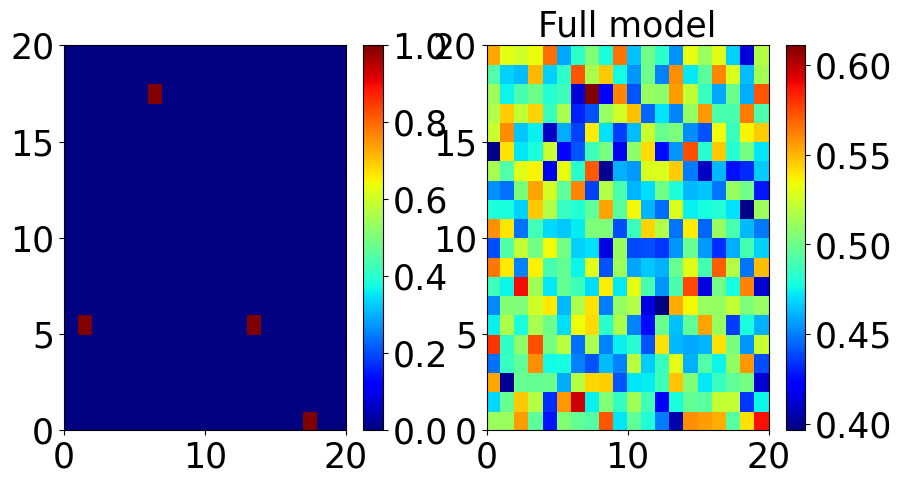

epoch: 3300, train loss: 1.1810466274619102, L1 loss: -1, val loss: 0.03686928004026413, max avg inners: 0.0813801210176025, GELMA loss: -0.18442518505483824, num indices: 0
epoch: 3301, train loss: 1.1809360422194004, L1 loss: -1, val loss: 0.03687011078000069, max avg inners: 0.08120091378294196, GELMA loss: -0.3492677095229859, num indices: 0
epoch: 3302, train loss: 1.1806041225790977, L1 loss: -1, val loss: 0.03686771169304848, max avg inners: 0.0815044886848786, GELMA loss: 0.5993322966920874, num indices: 0
epoch: 3303, train loss: 1.180784098803997, L1 loss: -1, val loss: 0.036868467926979065, max avg inners: 0.08154105192286541, GELMA loss: 0.04615252573378392, num indices: 0
epoch: 3304, train loss: 1.1808033399283886, L1 loss: -1, val loss: 0.03686557337641716, max avg inners: 0.08146262051590286, GELMA loss: 0.34515846152827967, num indices: 0
epoch: 3305, train loss: 1.1808152943849564, L1 loss: -1, val loss: 0.03687328100204468, max avg inners: 0.08143671440889479, GELMA 

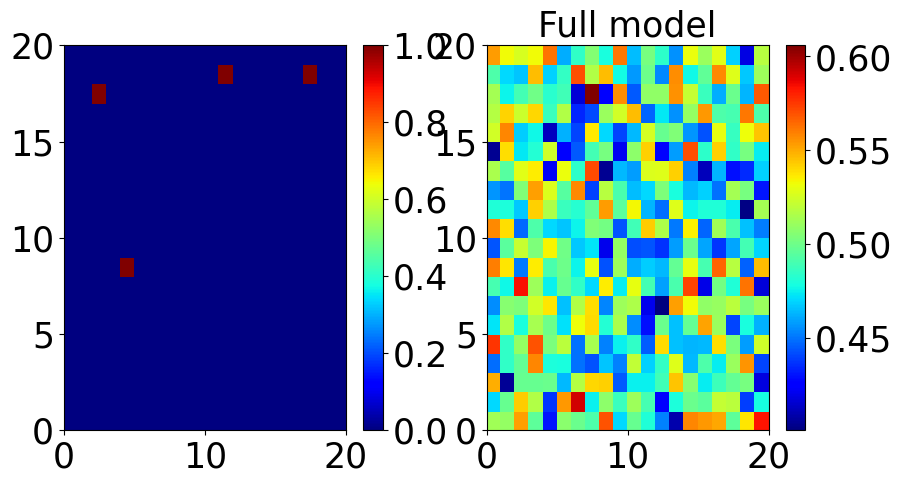

epoch: 3400, train loss: 1.1808992512524128, L1 loss: -1, val loss: 0.03687078133225441, max avg inners: 0.08142728769581663, GELMA loss: 0.31234414045385206, num indices: 0
epoch: 3401, train loss: 1.1809021569788456, L1 loss: -1, val loss: 0.036867544054985046, max avg inners: 0.0814970689361079, GELMA loss: 0.34938012667695434, num indices: 0
epoch: 3402, train loss: 1.1808972880244255, L1 loss: -1, val loss: 0.03686793893575668, max avg inners: 0.08134090152114341, GELMA loss: -0.38322377807075314, num indices: 0
epoch: 3403, train loss: 1.1806674972176552, L1 loss: -1, val loss: 0.03686586022377014, max avg inners: 0.08162786801360167, GELMA loss: -0.003411527765462651, num indices: 0
epoch: 3404, train loss: 1.1806741021573544, L1 loss: -1, val loss: 0.03686771169304848, max avg inners: 0.08131678022885155, GELMA loss: -0.058737360761006545, num indices: 0
epoch: 3405, train loss: 1.1808004342019558, L1 loss: -1, val loss: 0.03687180206179619, max avg inners: 0.08150947354814343,

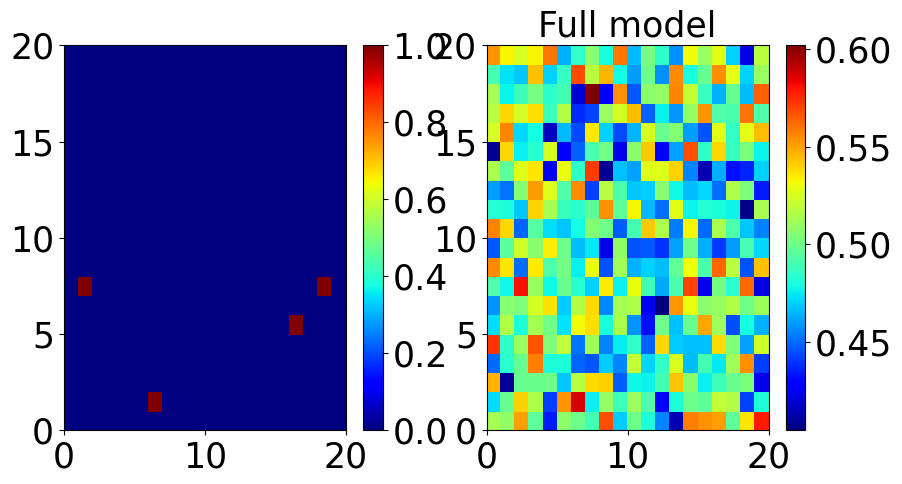

epoch: 3500, train loss: 1.1808743998408318, L1 loss: -1, val loss: 0.0368722565472126, max avg inners: 0.08152686478709277, GELMA loss: -0.08306105004193665, num indices: 0
epoch: 3501, train loss: 1.180895160883665, L1 loss: -1, val loss: 0.03686915710568428, max avg inners: 0.08165257163762536, GELMA loss: 0.05075186500653802, num indices: 0
epoch: 3502, train loss: 1.181031558662653, L1 loss: -1, val loss: 0.03686792403459549, max avg inners: 0.08142051726446349, GELMA loss: 0.45211564111868513, num indices: 0
epoch: 3503, train loss: 1.1807508654892445, L1 loss: -1, val loss: 0.036862850189208984, max avg inners: 0.08158909011852672, GELMA loss: -0.660349109140939, num indices: 0
epoch: 3504, train loss: 1.1807975992560387, L1 loss: -1, val loss: 0.03686356917023659, max avg inners: 0.08152710115182325, GELMA loss: -0.12762953482884887, num indices: 0
epoch: 3505, train loss: 1.1806031838059425, L1 loss: -1, val loss: 0.03687132149934769, max avg inners: 0.08129148190656021, GELMA

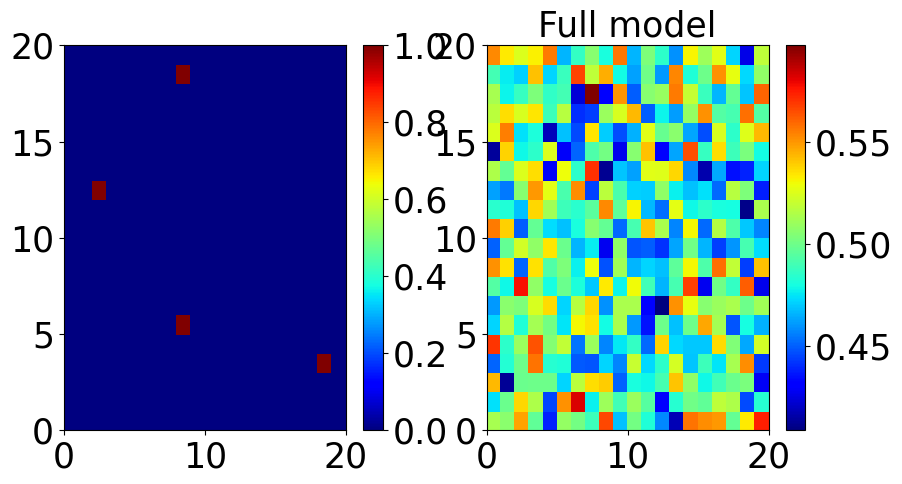

epoch: 3600, train loss: 1.1807270348072052, L1 loss: -1, val loss: 0.03686896339058876, max avg inners: 0.08148807753564556, GELMA loss: 0.708081268603291, num indices: 0
epoch: 3601, train loss: 1.1807663924992085, L1 loss: -1, val loss: 0.03686622530221939, max avg inners: 0.08166262340998234, GELMA loss: 0.07968717884667986, num indices: 0
epoch: 3602, train loss: 1.1808792650699615, L1 loss: -1, val loss: 0.03686864301562309, max avg inners: 0.08150058853949183, GELMA loss: -0.0014067665256269626, num indices: 0
epoch: 3603, train loss: 1.1808175705373287, L1 loss: -1, val loss: 0.03686835244297981, max avg inners: 0.08149144619167913, GELMA loss: 0.2522641199748842, num indices: 0
epoch: 3604, train loss: 1.1808378994464874, L1 loss: -1, val loss: 0.03686647489666939, max avg inners: 0.08157132003231665, GELMA loss: -0.5128070870366727, num indices: 0
epoch: 3605, train loss: 1.1809074319899082, L1 loss: -1, val loss: 0.03686270862817764, max avg inners: 0.08168598815198135, GELM

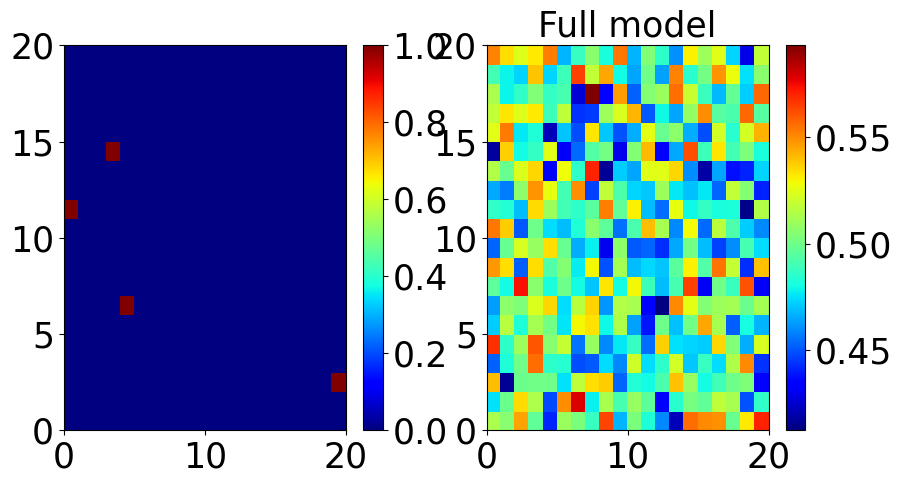

epoch: 3700, train loss: 1.1806495375931263, L1 loss: -1, val loss: 0.036869730800390244, max avg inners: 0.0814972592425762, GELMA loss: -0.32543654343110456, num indices: 0
epoch: 3701, train loss: 1.1808001771569252, L1 loss: -1, val loss: 0.03686884418129921, max avg inners: 0.08144647845038082, GELMA loss: -0.2827314715711477, num indices: 0
epoch: 3702, train loss: 1.1807831898331642, L1 loss: -1, val loss: 0.03686476871371269, max avg inners: 0.08150602460182706, GELMA loss: -0.45680804482779636, num indices: 0
epoch: 3703, train loss: 1.180746529251337, L1 loss: -1, val loss: 0.0368666872382164, max avg inners: 0.08149256395451818, GELMA loss: 0.31237794236240346, num indices: 0
epoch: 3704, train loss: 1.1807947307825089, L1 loss: -1, val loss: 0.03686691075563431, max avg inners: 0.0816078579595379, GELMA loss: -0.2841652865926124, num indices: 0
epoch: 3705, train loss: 1.1806956380605698, L1 loss: -1, val loss: 0.036870405077934265, max avg inners: 0.08149675286272716, GELM

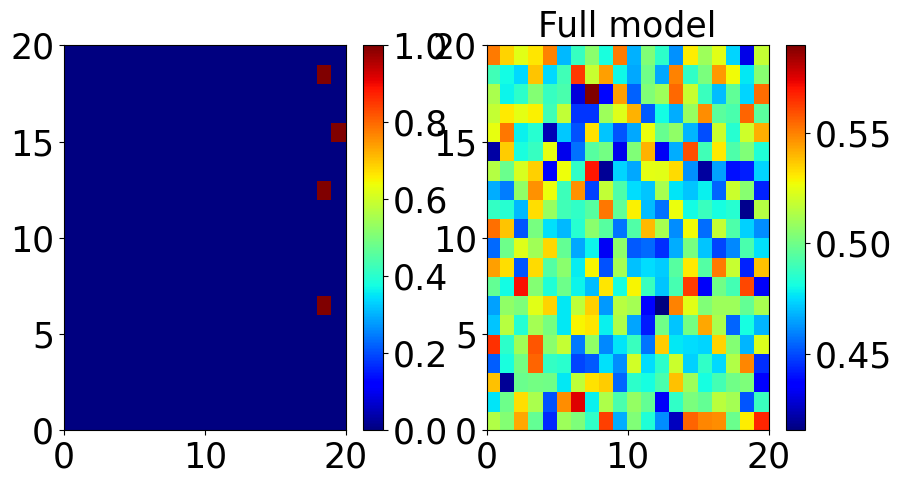

epoch: 3800, train loss: 1.1809471622109413, L1 loss: -1, val loss: 0.036866627633571625, max avg inners: 0.08154504064896212, GELMA loss: -0.7720070039512507, num indices: 0
epoch: 3801, train loss: 1.1806314326822758, L1 loss: -1, val loss: 0.03686561807990074, max avg inners: 0.08141900859130179, GELMA loss: -0.1732132878647189, num indices: 0
epoch: 3802, train loss: 1.180735070258379, L1 loss: -1, val loss: 0.03686525672674179, max avg inners: 0.08167710712552978, GELMA loss: -0.06511449976731676, num indices: 0
epoch: 3803, train loss: 1.1808663196861744, L1 loss: -1, val loss: 0.0368662104010582, max avg inners: 0.0816174776412766, GELMA loss: 0.4530130725263011, num indices: 0
epoch: 3804, train loss: 1.180900502949953, L1 loss: -1, val loss: 0.03686707839369774, max avg inners: 0.08136058009889241, GELMA loss: -0.43349581876500626, num indices: 0
epoch: 3805, train loss: 1.1808586418628693, L1 loss: -1, val loss: 0.03686826676130295, max avg inners: 0.08149799667591569, GELMA 

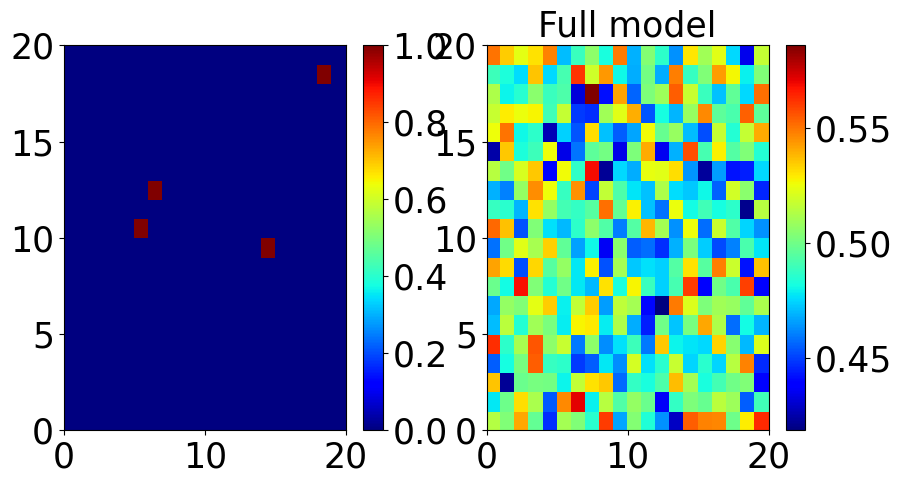

epoch: 3900, train loss: 1.180763315409422, L1 loss: -1, val loss: 0.03686254471540451, max avg inners: 0.0814814267780319, GELMA loss: -0.577716068817717, num indices: 0
epoch: 3901, train loss: 1.1808080561459064, L1 loss: -1, val loss: 0.03686812147498131, max avg inners: 0.0813268257713509, GELMA loss: 0.3405664841629773, num indices: 0
epoch: 3902, train loss: 1.1807137466967106, L1 loss: -1, val loss: 0.036864813417196274, max avg inners: 0.08166205426008888, GELMA loss: -0.8037555987593548, num indices: 0
epoch: 3903, train loss: 1.1809745877981186, L1 loss: -1, val loss: 0.03686489537358284, max avg inners: 0.08162227085839843, GELMA loss: -0.3277268411111414, num indices: 0
epoch: 3904, train loss: 1.1810188554227352, L1 loss: -1, val loss: 0.036866042762994766, max avg inners: 0.08163486443538655, GELMA loss: 0.4674974947430272, num indices: 0
epoch: 3905, train loss: 1.1806927658617496, L1 loss: -1, val loss: 0.0368659608066082, max avg inners: 0.08152923935288023, GELMA los

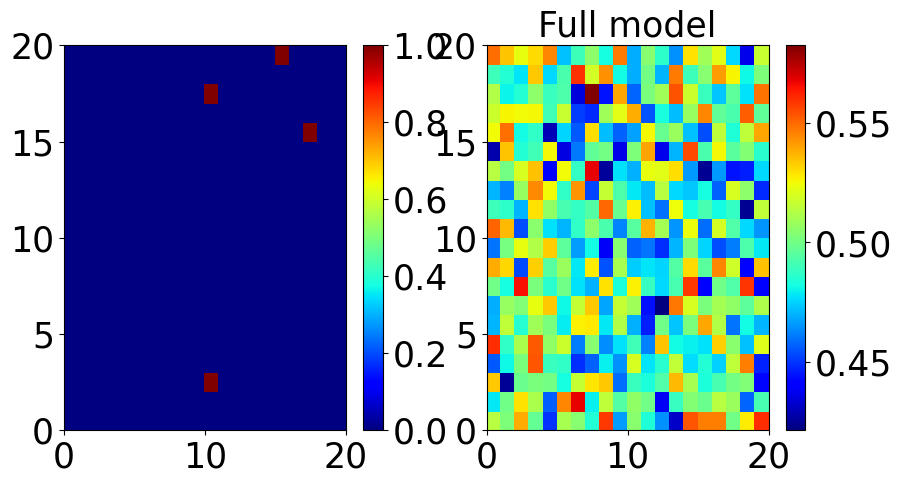

epoch: 4000, train loss: 1.1807053200900555, L1 loss: -1, val loss: 0.036867983639240265, max avg inners: 0.08137998241934659, GELMA loss: -0.42338671876754264, num indices: 0
epoch: 4001, train loss: 1.1808417178690434, L1 loss: -1, val loss: 0.036866072565317154, max avg inners: 0.08168917667810521, GELMA loss: 0.15008735611076557, num indices: 0
epoch: 4002, train loss: 1.180833037942648, L1 loss: -1, val loss: 0.03686988726258278, max avg inners: 0.08122326929420799, GELMA loss: -1.2442436480341657, num indices: 0
epoch: 4003, train loss: 1.1808559447526932, L1 loss: -1, val loss: 0.03686884418129921, max avg inners: 0.0811258333566423, GELMA loss: -0.2975594715271039, num indices: 0
epoch: 4004, train loss: 1.1808363869786263, L1 loss: -1, val loss: 0.03686736151576042, max avg inners: 0.08156925050955152, GELMA loss: 0.17291915567378482, num indices: 0
epoch: 4005, train loss: 1.180812157690525, L1 loss: -1, val loss: 0.036867570132017136, max avg inners: 0.08150902357779827, GEL

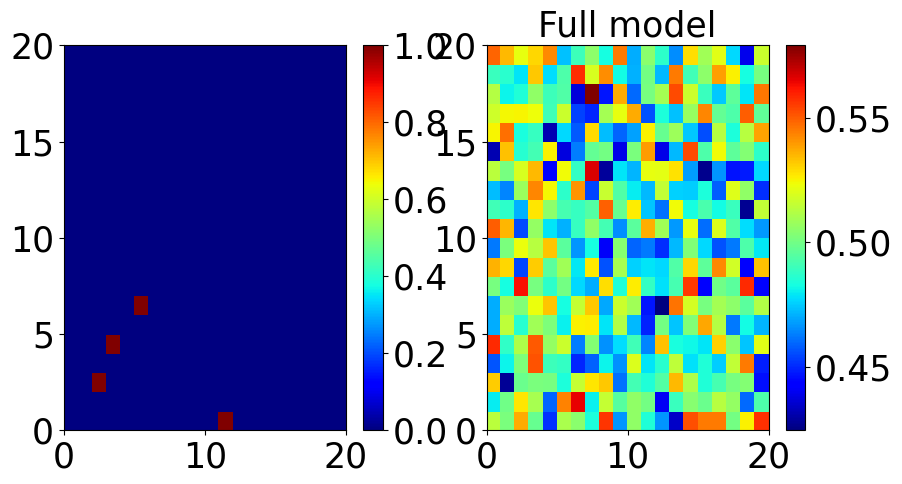

epoch: 4100, train loss: 1.1805303432047367, L1 loss: -1, val loss: 0.036865606904029846, max avg inners: 0.08162903309590495, GELMA loss: -0.24220938890472238, num indices: 0
epoch: 4101, train loss: 1.180796280503273, L1 loss: -1, val loss: 0.03686745837330818, max avg inners: 0.08160438431210838, GELMA loss: -0.5372535166856158, num indices: 0
epoch: 4102, train loss: 1.1808437816798687, L1 loss: -1, val loss: 0.03686664253473282, max avg inners: 0.08162663321624818, GELMA loss: -0.5483660595580002, num indices: 0
epoch: 4103, train loss: 1.1806512661278248, L1 loss: -1, val loss: 0.036863572895526886, max avg inners: 0.08164955205636751, GELMA loss: 0.511185124821799, num indices: 0
epoch: 4104, train loss: 1.1809487901628017, L1 loss: -1, val loss: 0.03686458244919777, max avg inners: 0.08154090887688073, GELMA loss: -0.02823099270961009, num indices: 0
epoch: 4105, train loss: 1.1807833202183247, L1 loss: -1, val loss: 0.036866769194602966, max avg inners: 0.0813750329228217, GEL

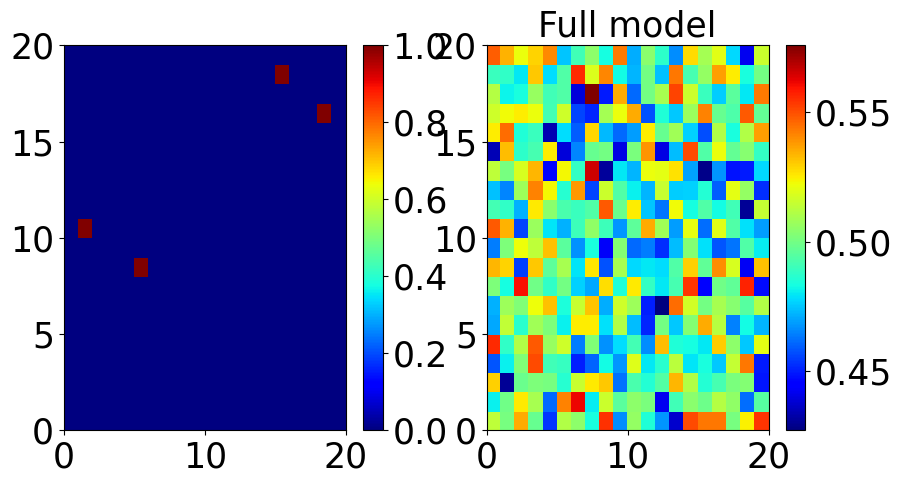

epoch: 4200, train loss: 1.1805867962539196, L1 loss: -1, val loss: 0.03686333820223808, max avg inners: 0.08164052030989502, GELMA loss: -0.3976056298915227, num indices: 0
epoch: 4201, train loss: 1.1809307411313057, L1 loss: -1, val loss: 0.03686177358031273, max avg inners: 0.08172851359841465, GELMA loss: -0.1435129775417533, num indices: 0
epoch: 4202, train loss: 1.1806739456951618, L1 loss: -1, val loss: 0.036865364760160446, max avg inners: 0.08180519849486721, GELMA loss: -0.08058344558399332, num indices: 0
epoch: 4203, train loss: 1.1804818622767925, L1 loss: -1, val loss: 0.036867257207632065, max avg inners: 0.08168995912869263, GELMA loss: -0.08017748519168699, num indices: 0
epoch: 4204, train loss: 1.1806962378323078, L1 loss: -1, val loss: 0.036870915442705154, max avg inners: 0.0814536044594896, GELMA loss: -0.559264779550762, num indices: 0
epoch: 4205, train loss: 1.1807736717164516, L1 loss: -1, val loss: 0.03687427192926407, max avg inners: 0.08133534274989085, G

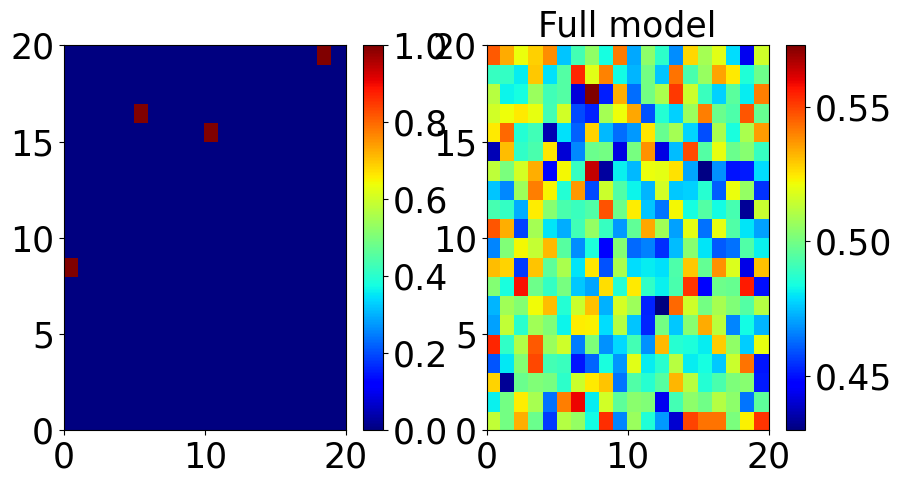

epoch: 4300, train loss: 1.1805302128195763, L1 loss: -1, val loss: 0.03686535358428955, max avg inners: 0.08176367819519685, GELMA loss: 0.31881997203340723, num indices: 0
epoch: 4301, train loss: 1.1807270012795925, L1 loss: -1, val loss: 0.03686689957976341, max avg inners: 0.08177775174338425, GELMA loss: -0.3323924309335161, num indices: 0
epoch: 4302, train loss: 1.1806596703827381, L1 loss: -1, val loss: 0.03686617687344551, max avg inners: 0.08156995495132, GELMA loss: -0.087128555194211, num indices: 0
epoch: 4303, train loss: 1.1809519715607166, L1 loss: -1, val loss: 0.036866020411252975, max avg inners: 0.0817153681301003, GELMA loss: 0.09017269896241435, num indices: 0
epoch: 4304, train loss: 1.1804302372038364, L1 loss: -1, val loss: 0.03686303645372391, max avg inners: 0.08167691515776741, GELMA loss: -0.05980775232598486, num indices: 0
epoch: 4305, train loss: 1.1806653812527657, L1 loss: -1, val loss: 0.0368669331073761, max avg inners: 0.08158377757531401, GELMA lo

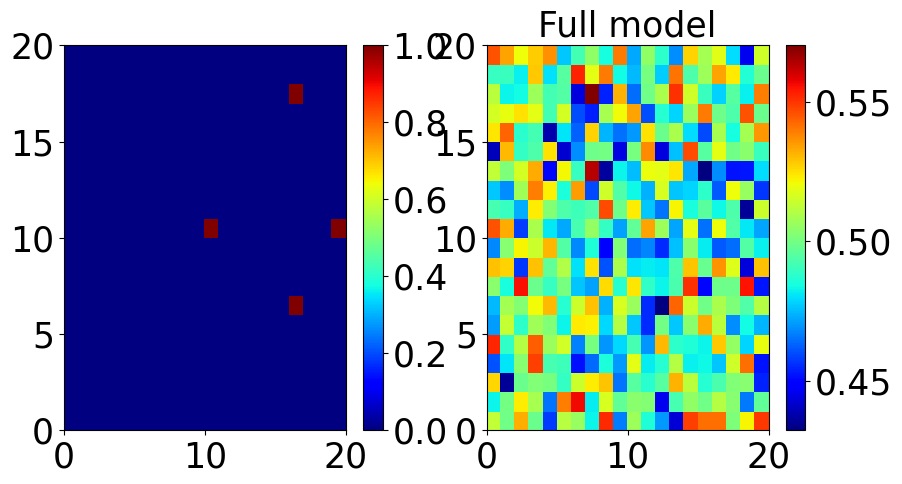

epoch: 4400, train loss: 1.1807026751339436, L1 loss: -1, val loss: 0.03686768561601639, max avg inners: 0.0815773257588574, GELMA loss: -0.1585594987632113, num indices: 0
epoch: 4401, train loss: 1.180848989635706, L1 loss: -1, val loss: 0.03686726465821266, max avg inners: 0.08145327662348377, GELMA loss: 0.595481314336955, num indices: 0
epoch: 4402, train loss: 1.1806350089609623, L1 loss: -1, val loss: 0.036865994334220886, max avg inners: 0.08183433377264861, GELMA loss: -0.1541169565386503, num indices: 0
epoch: 4403, train loss: 1.1806622371077538, L1 loss: -1, val loss: 0.036865461617708206, max avg inners: 0.08142668686499807, GELMA loss: -0.37163896139071523, num indices: 0
epoch: 4404, train loss: 1.1807163618505, L1 loss: -1, val loss: 0.03686824440956116, max avg inners: 0.08168035171692392, GELMA loss: 0.6680708203067869, num indices: 0
epoch: 4405, train loss: 1.1807539463043213, L1 loss: -1, val loss: 0.03686447814106941, max avg inners: 0.0815296995397887, GELMA loss

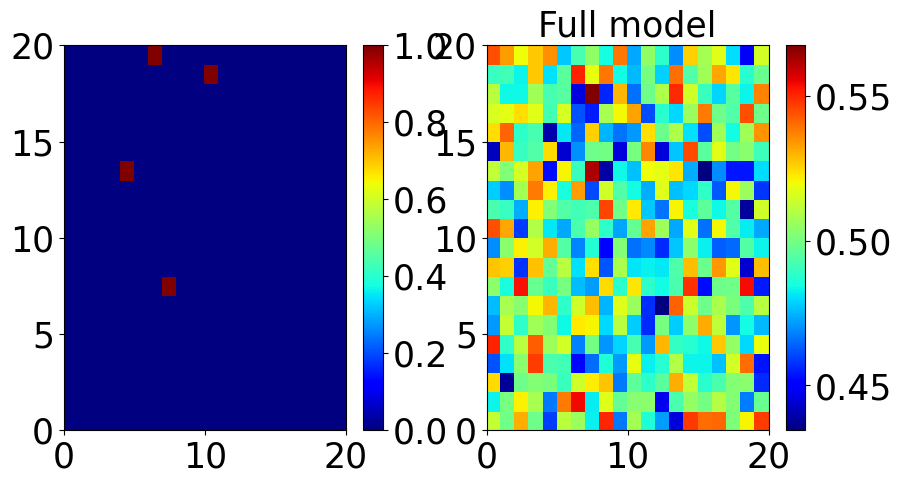

epoch: 4500, train loss: 1.180925939232111, L1 loss: -1, val loss: 0.036861155182123184, max avg inners: 0.08178106346539066, GELMA loss: 0.3697251963255126, num indices: 0
epoch: 4501, train loss: 1.1805845722556114, L1 loss: -1, val loss: 0.03686352074146271, max avg inners: 0.08163266095605332, GELMA loss: 0.005950783235230478, num indices: 0
epoch: 4502, train loss: 1.1807381957769394, L1 loss: -1, val loss: 0.036863166838884354, max avg inners: 0.08165064897884747, GELMA loss: 0.38355025633236045, num indices: 0
epoch: 4503, train loss: 1.1806149706244469, L1 loss: -1, val loss: 0.03686454892158508, max avg inners: 0.08171713024601393, GELMA loss: -0.059328741959422754, num indices: 0
epoch: 4504, train loss: 1.180789452046156, L1 loss: -1, val loss: 0.0368613563477993, max avg inners: 0.0816088441122993, GELMA loss: 0.553660121357458, num indices: 0
epoch: 4505, train loss: 1.1804310716688633, L1 loss: -1, val loss: 0.03686310723423958, max avg inners: 0.08154878875858422, GELMA 

KeyboardInterrupt: 

In [43]:
#Raw data training unlabeled only
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=1e-15
G_0=False
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
#decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, layers[::-1], indim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>0:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled no batching
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=1e-15
layers=[5000,5000,5000,3000,3000,1400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
b_train=training_data.b.to(device)
rho_train=training_data.rho.to(device)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    if True:
        b=b_train
        rho=rho_train
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        if KM_in:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            Mhat_imag=-Mhat_imag
            b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
            
        # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
            In_put=torch.cat((b, km_b), dim=-1)

            rho_hat=encoder(In_put)
        else:
            rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        if CE:
            rho_hat_hat=encoder(b_hat)

            CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
            CEloss.backward(retain_graph=True)
            CEloss=CEloss.item()

        
        if GELMA>0 and epoch>100:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg=inner_loss_term.item()/GELMA
            optimizer_GELMA.step()
            
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    #if epoch%10000==0:
    #   H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training variational autoencoder (KL replcaed with BCE)
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
layers=[500,500,500,300,300,300,400,800]
G_0=False
Epochs=10000
index_list=[]
KL_weight=1
L1_weight=1e-3

Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=512
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.variational_enc(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, [layers[len(layers)-i-1] for i in range(len(layers))],training_data.b[0].shape[0]/2 , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
L1_loss_fn=nn.L1Loss()
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)

lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    encoder.train()
    decoder.train()
    KL_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)

        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        rho_hat_mean, rho_hat_logvar=encoder(b)
        rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
        KLloss=H.KL_divergence(rho_hat_mean, rho_hat_logvar)*KL_weight
        KLloss.backward(retain_graph=True)
        #rho_hat=sigmoid(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()/len(trainloader)
        KL_lossavg+=KLloss.item()/len(trainloader)/KL_weight
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat_mean, rho_hat_logvar=encoder(b_val)
    rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
    #rho_hat=softmax(rho_hat)
    #rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        #Complex_eye=Complex_eye+
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, KL_LOSS: {KL_lossavg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original},  num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled only. Encoder decoder alternation
starttime=time.time()
target='raw'
unlabeled_data=10000
L1_weight=0.005
GELMA=0.0
G_0=False
Epochs=100000
layers=[128]*14
GELMA_layers=[128]*5
GELMA_layers.append(500)
layers.append(500)



Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128

#training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
b=training_data.b.to(device)
rho=training_data.rho.to(device)
rh_t, _=torch.split(rho, 400, dim=-1)


#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.Adam(decoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)

if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()


for epoch in range(Epochs):
    encoder.train()
    decoder.train()
    train_lossavg=0
    train_lossavg=0
    train_lossavg_decoder=0
    inner_loss_term_avg=0
    L1_loss_avg=0
    for param in encoder.parameters():
        param.requires_grad = True
    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()


        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss_avg+=L1_loss.item()/L1_weight/15
            #if L1_loss>5e-15:
                #L1_weight=L1_weight*0.999
        else:
            L1_loss=-1

        if GELMA>0:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg+=inner_loss_term.item()/GELMA/15
            optimizer_GELMA.step()
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


    
        optimizer.step()
        train_lossavg+=L2_loss.item()/15
    for param in encoder.parameters():
        param.requires_grad = False


    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)


        
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()



        optimizer_decod.step()
        train_lossavg_decoder+=L2_loss.item()/15
    
    
    val_lossavg=0
    if epoch%1000==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%1000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%100==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            index_of_max=np.argmax(torch_inners[:,i])
            torch_inners[:,index_of_max]=0*torch_inners[index_of_max,:]
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        
        
        
        print(f'epoch: {epoch}, Encoder train loss: {train_lossavg}, Decoder train loss: {train_lossavg_decoder} L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}')
        
    if Track_run:
        wandb.log(wand_dict)


if Track_run:
    wandb.finish()


In [ ]:
#cc data training
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

labeled_data=400
layer_loss_list=[]
Epochs=3000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    bce_loss.backward() 
    train_lossavg+=bce_loss.item()
    accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()
    accuracy_val=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}, train accuracy: {accuracy_train}, val accuracy: {accuracy_val}')


torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [9]:
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_lowcow.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat_orderer))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,training_data[0][0].shape[0], bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_long_bigdata/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_30-May-2024 (23:10:16)decoder.pt' #.61 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (23:10:30)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (21:26:12)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (23:29:19)decoder.pt' #.92 random init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init


decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 12124.0 400.0
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(12124,) (400, 12124)
torch.Size([400, 24248])
torch.Size([400, 400])
(400, 1450) (400, 1450)
0.9954802301497007


In [ ]:
#function doing above
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(1):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Permutes the columns with inerse perm matrix.
Perm=orderer(cc_medium)
softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
hope=torch.tensor(np.linalg.inv(Perm.cpu().detach().numpy())).round()
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Compares the behavior of different decoder networks trained with different random realizations and different
#SGD randomness. 
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat1='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
locat2='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (10:33:30)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (07:51:38)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (02:50:48)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
for j in range(5):
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    larger_than=0
    sum_max_noreplace_original=0
    for i in range(400):
        if max(torch_inners[i,:])>.90:
            larger_than+=1
            total_list[j].append(i)
        sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
    print(larger_than)    


In [ ]:
####Tests orderer on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
print(training_data.b.shape)
data_path_G0_list=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

#original_G= np.array(mat73.loadmat(data_path_G0_list+'/rtt_array.mat')['RM_realization_list'])
print(original_G.shape)
training_data.b=original_G[58].T
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'

orderer.load_state_dict(torch.load(Locat_orderer))
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.train()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):

    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')


In [ ]:
####Tests if just looking at  proximoity of random media, and homo media data.
labeled_data=1000
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
test_cc=training_data[0][0]
target=training_data[0][1]
dummies=[]
print(medium.shape)

In [ ]:
####Tests ordered on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
labeled_data=40
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)

orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
orderer.load_state_dict(torch.load(Locat_orderer))
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

training_data=H.data_rho_CC_IID(data_path+'/train',labeled_data/80000)
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.eval()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):
    
    b=b.to(device)  
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    curr_acc=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if curr_acc<1.0:
        print(curr_acc)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)
    

print(f'accuracy: {accuracy}, loss: {lossavg}')

0.9954802301497007
(1450, 400)


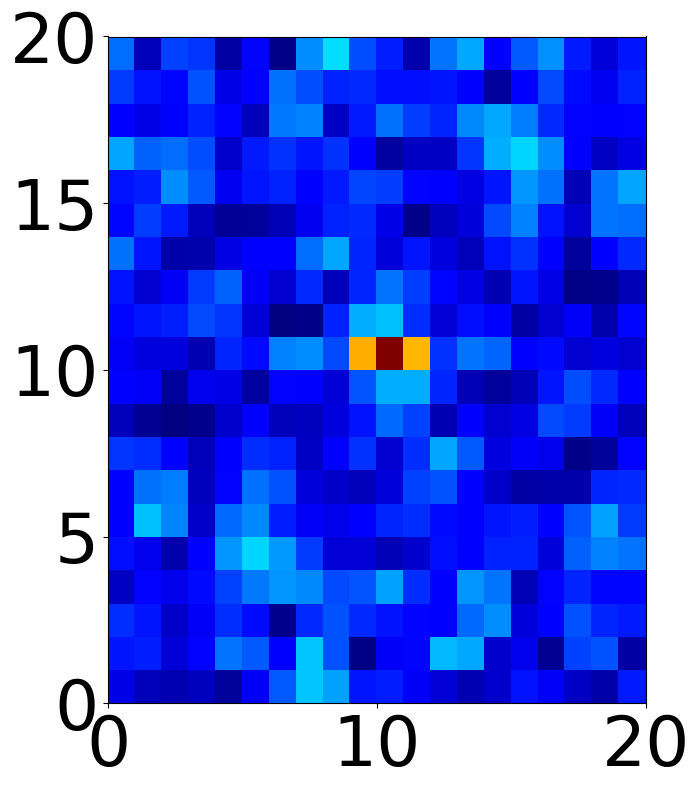

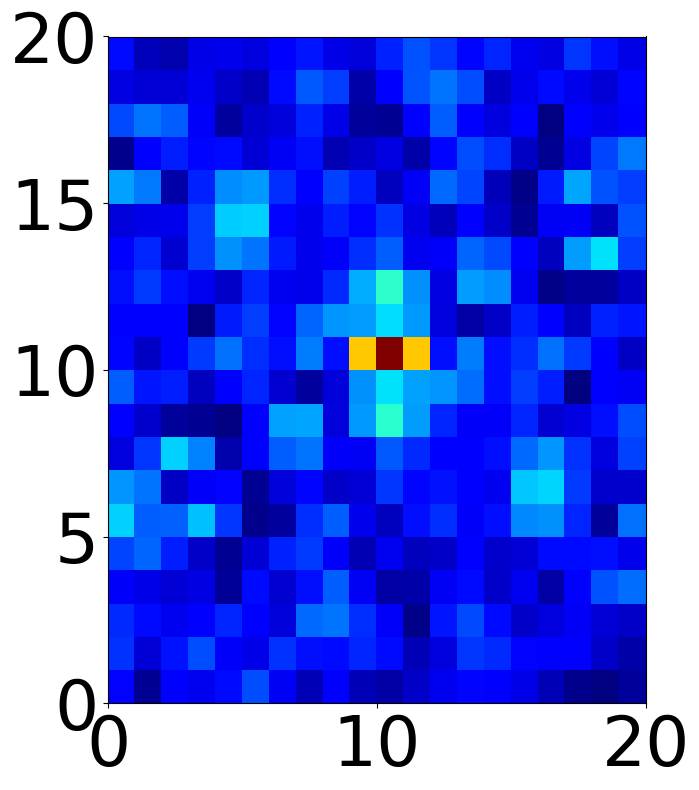

In [39]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T*(1+np.random.randn(1450)*5)
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()

    b=sensing@rho.T
    img=np.linalg.pinv(sensing_hat)@b
        
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    #cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat',SAME_bar=pcol_Used)
img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho',SAME_bar=pcol_Used)

In [ ]:
#Raw data training unlabeled conv layers
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')

unlabeled_data=5000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[32]*11
CE=False
KM_in=False

CONV=True

#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2

if CONV:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='conv',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
else:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
    
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            #if CONV:
            ##    rho_hat=rho_hat.squeeze()
            #    rho_hat=softmax(rho_hat)
            #    rho_hat=rho_hat*4
            #else:
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
  #  if epoch%10000==0:
      # H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
21376002
Data shapes: 725.0 0.5


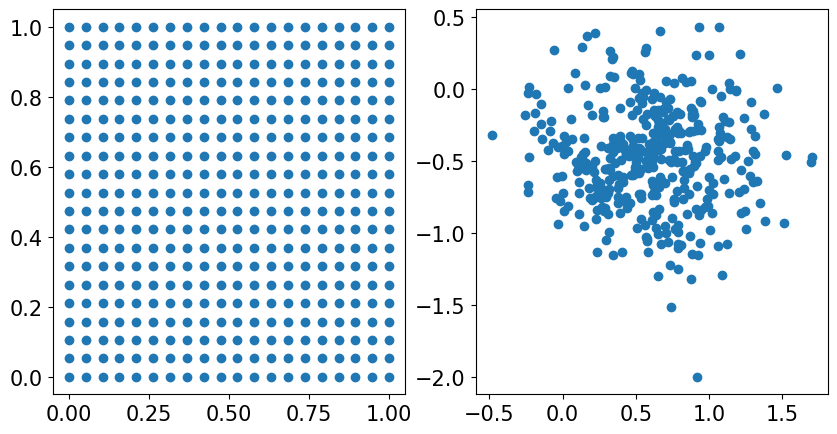

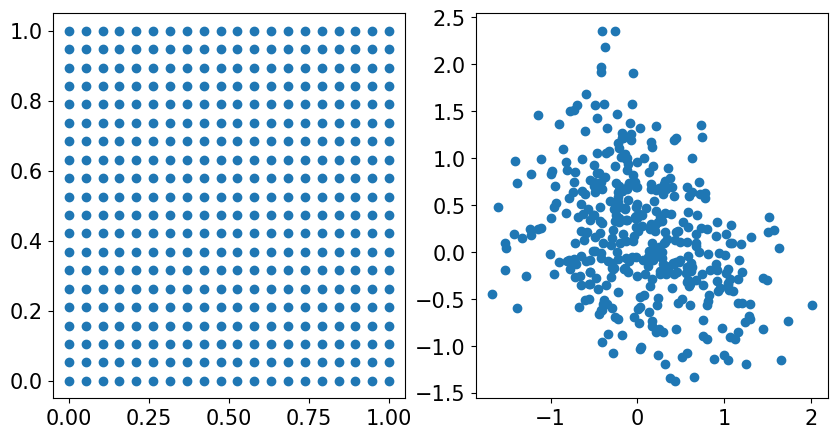

epoch: 0, train loss: 0.6664894223213196, val loss: 0.5722724795341492
epoch: 1, train loss: 0.5703892111778259, val loss: 2.5114874839782715
epoch: 2, train loss: 2.507040023803711, val loss: 4.031868934631348
epoch: 3, train loss: 4.037278175354004, val loss: 1.0661447048187256
epoch: 4, train loss: 1.0620735883712769, val loss: 0.6314690113067627
epoch: 5, train loss: 0.6278542876243591, val loss: 0.28711989521980286
epoch: 6, train loss: 0.2895497977733612, val loss: 0.14082175493240356
epoch: 7, train loss: 0.1381450742483139, val loss: 0.08812141418457031
epoch: 8, train loss: 0.0884886309504509, val loss: 0.12872415781021118
epoch: 9, train loss: 0.13116396963596344, val loss: 0.11523403227329254
epoch: 10, train loss: 0.11492250859737396, val loss: 0.1160854697227478
epoch: 11, train loss: 0.11361556500196457, val loss: 0.08058925718069077
epoch: 12, train loss: 0.07902620732784271, val loss: 0.03785981237888336
epoch: 13, train loss: 0.038419537246227264, val loss: 0.034819420

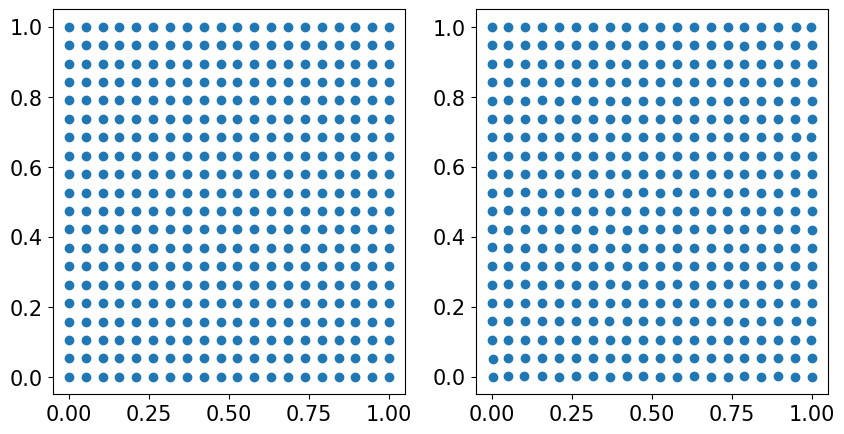

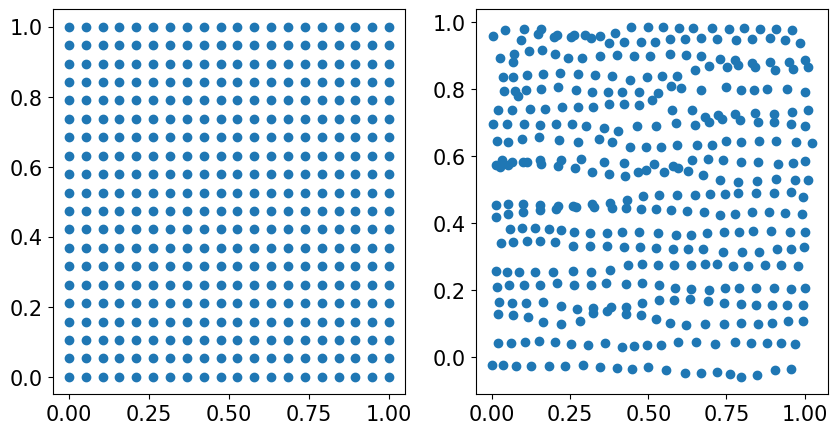

epoch: 500, train loss: 3.001624975240702e-07, val loss: 0.0003813796502072364
epoch: 501, train loss: 2.9636967724400165e-07, val loss: 0.00038142030825838447
epoch: 502, train loss: 2.926759634647169e-07, val loss: 0.0003814183874055743
epoch: 503, train loss: 2.8904551641062426e-07, val loss: 0.00038136012153699994
epoch: 504, train loss: 2.854825424947194e-07, val loss: 0.00038135945214889944
epoch: 505, train loss: 2.8197680990160734e-07, val loss: 0.0003814000519923866
epoch: 506, train loss: 2.785371862046304e-07, val loss: 0.00038137330557219684
epoch: 507, train loss: 2.7519567424860725e-07, val loss: 0.000381322082830593
epoch: 508, train loss: 2.719204701406852e-07, val loss: 0.0003813318908214569
epoch: 509, train loss: 2.686680886654358e-07, val loss: 0.00038134833448566496
epoch: 510, train loss: 2.6550299025984714e-07, val loss: 0.0003813193761743605
epoch: 511, train loss: 2.623800412493438e-07, val loss: 0.0003813108487520367
epoch: 512, train loss: 2.593026806607668e-

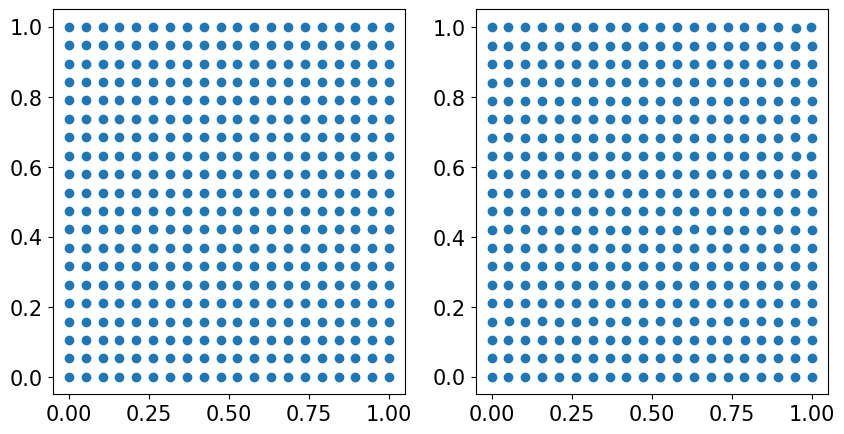

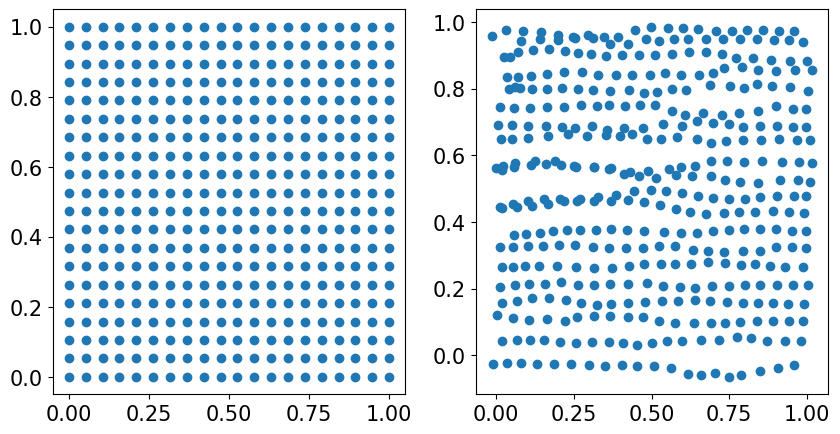

epoch: 1000, train loss: 1.7024601106641057e-07, val loss: 0.0003365176962688565
epoch: 1001, train loss: 1.6848923678480787e-07, val loss: 0.000336522760335356
epoch: 1002, train loss: 1.6677276448717748e-07, val loss: 0.00033648876706138253
epoch: 1003, train loss: 1.6508765554590354e-07, val loss: 0.0003364646981935948
epoch: 1004, train loss: 1.6344567654869024e-07, val loss: 0.0003364744770806283
epoch: 1005, train loss: 1.618258096414138e-07, val loss: 0.00033644482027739286
epoch: 1006, train loss: 1.6023648186092032e-07, val loss: 0.0003364338190294802
epoch: 1007, train loss: 1.586655287155736e-07, val loss: 0.0003364139702171087
epoch: 1008, train loss: 1.5712042511495383e-07, val loss: 0.00033640291076153517
epoch: 1009, train loss: 1.556038569106022e-07, val loss: 0.00033638151944614947
epoch: 1010, train loss: 1.5411582410251867e-07, val loss: 0.00033636175794526935
epoch: 1011, train loss: 1.526516655303567e-07, val loss: 0.0003363620489835739
epoch: 1012, train loss: 1.5

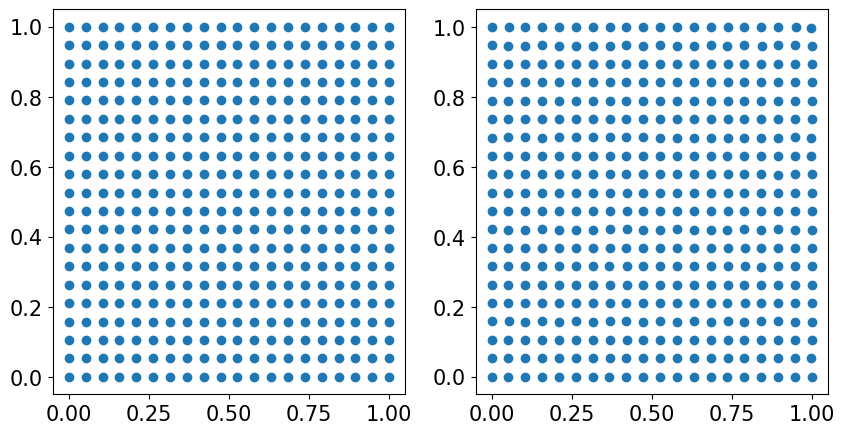

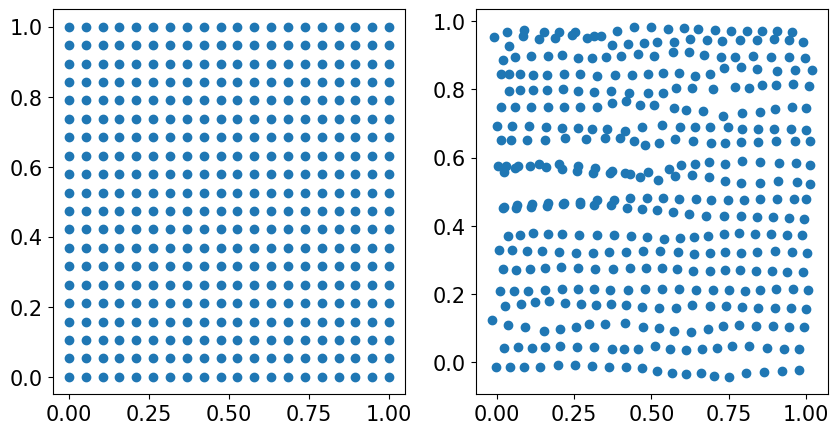

epoch: 1500, train loss: 1.7022193787852302e-07, val loss: 0.00025051343254745007
epoch: 1501, train loss: 1.6570605509969027e-07, val loss: 0.00025072944117709994
epoch: 1502, train loss: 1.651248311418385e-07, val loss: 0.0002507308672647923
epoch: 1503, train loss: 1.5877570547218056e-07, val loss: 0.000250538025284186
epoch: 1504, train loss: 1.5754682181068347e-07, val loss: 0.0002510646008886397
epoch: 1505, train loss: 1.5596930325045832e-07, val loss: 0.0002504833973944187
epoch: 1506, train loss: 1.4942311565846467e-07, val loss: 0.00025057565653696656
epoch: 1507, train loss: 1.4950225590837363e-07, val loss: 0.00025118235498666763
epoch: 1508, train loss: 1.4616860255500796e-07, val loss: 0.000250492274062708
epoch: 1509, train loss: 1.4322516506126703e-07, val loss: 0.0002505891025066376
epoch: 1510, train loss: 1.403860494519904e-07, val loss: 0.00025109827402047813
epoch: 1511, train loss: 1.3846900515090965e-07, val loss: 0.00025061596534214914
epoch: 1512, train loss: 1

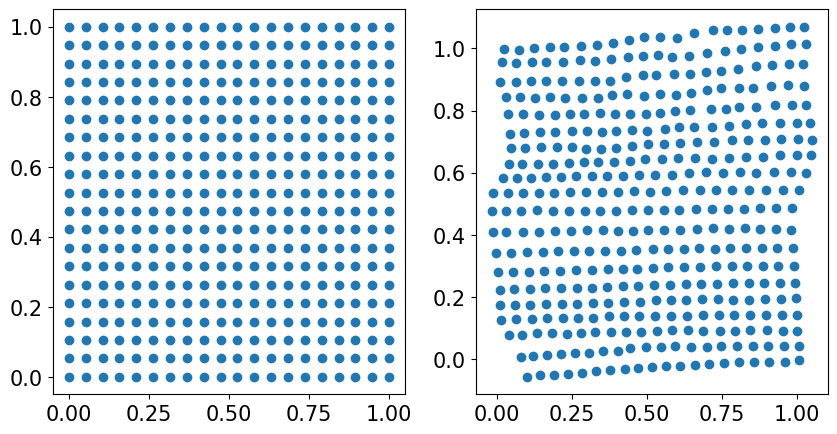

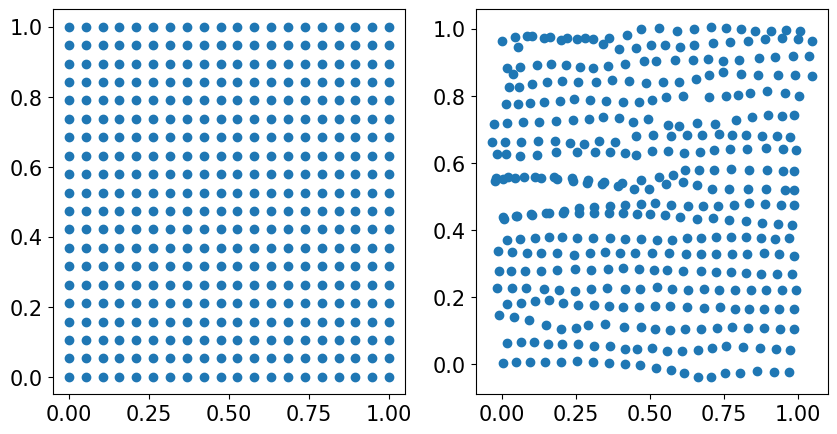

epoch: 2000, train loss: 0.0005612772074528039, val loss: 0.0003379614499863237
epoch: 2001, train loss: 0.0002899880928453058, val loss: 0.0012928870273754
epoch: 2002, train loss: 0.0007830957765690982, val loss: 0.0007975338376127183
epoch: 2003, train loss: 0.0007108224672265351, val loss: 0.0005399544606916606
epoch: 2004, train loss: 0.0003801806888077408, val loss: 0.00099323655012995
epoch: 2005, train loss: 0.000537501648068428, val loss: 0.0005582549492828548
epoch: 2006, train loss: 0.0005089766345918179, val loss: 0.00038199182017706335
epoch: 2007, train loss: 0.0001343952608294785, val loss: 0.000600059109274298
epoch: 2008, train loss: 0.0002357365156058222, val loss: 0.0005732541903853416
epoch: 2009, train loss: 0.0005004645208828151, val loss: 0.000561150663997978
epoch: 2010, train loss: 0.00027239316841587424, val loss: 0.0003964580537285656
epoch: 2011, train loss: 9.920328739099205e-05, val loss: 0.00035278103314340115
epoch: 2012, train loss: 0.000240958295762538

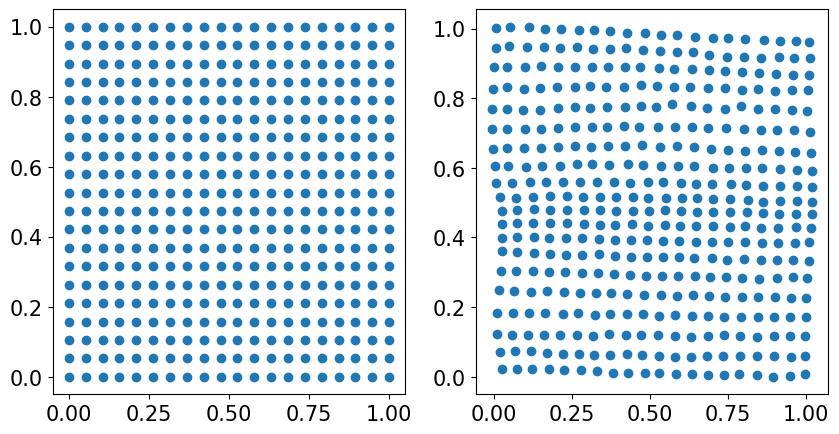

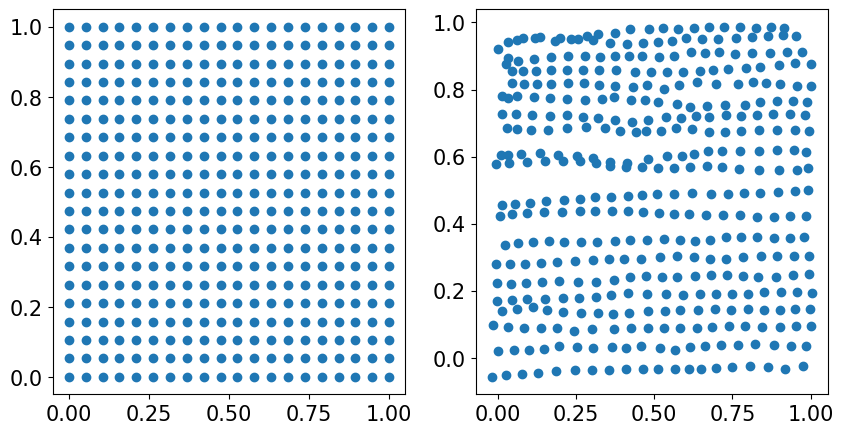

epoch: 2500, train loss: 0.00030314791365526617, val loss: 0.0006176628521643579
epoch: 2501, train loss: 0.0003130544791929424, val loss: 0.00026354705914855003
epoch: 2502, train loss: 7.930454012239352e-05, val loss: 0.0005438547232188284
epoch: 2503, train loss: 0.00025166841805912554, val loss: 0.0004577695217449218
epoch: 2504, train loss: 0.0002539212873671204, val loss: 0.00036334263859316707
epoch: 2505, train loss: 6.706587737426162e-05, val loss: 0.0003714808844961226
epoch: 2506, train loss: 0.000167545149452053, val loss: 0.00036921616992913187
epoch: 2507, train loss: 0.000128495303215459, val loss: 0.0003211629227735102
epoch: 2508, train loss: 2.7976564524578862e-05, val loss: 0.00030633926508016884
epoch: 2509, train loss: 0.0001279959105886519, val loss: 0.00035035377368330956
epoch: 2510, train loss: 8.226662612287328e-05, val loss: 0.0003002234152518213
epoch: 2511, train loss: 3.8129666791064665e-05, val loss: 0.000311325304210186
epoch: 2512, train loss: 0.0001151

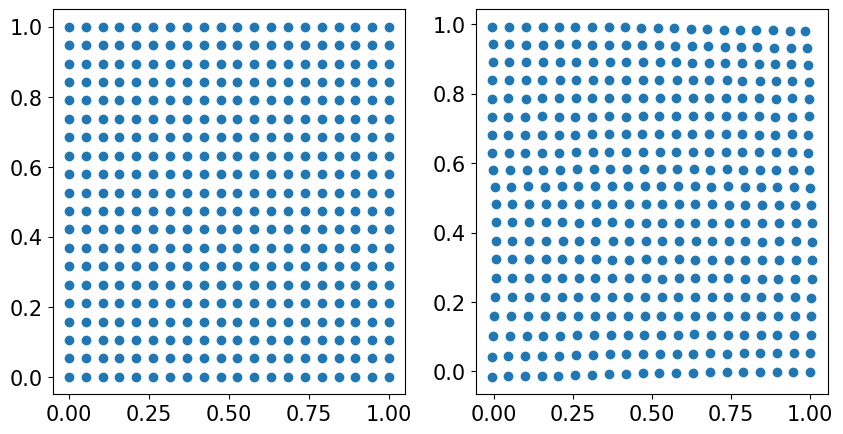

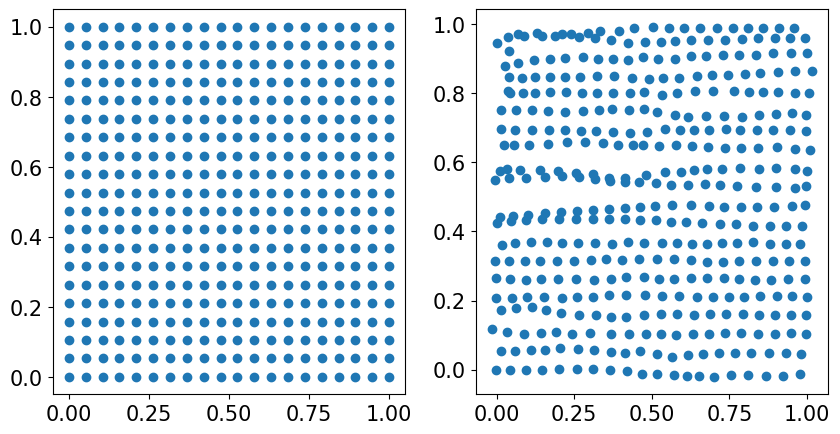

epoch: 3000, train loss: 2.9818847906426527e-05, val loss: 0.0002016070793615654
epoch: 3001, train loss: 5.207226422498934e-05, val loss: 0.00038707925705239177
epoch: 3002, train loss: 7.122150418581441e-05, val loss: 0.00022940896451473236
epoch: 3003, train loss: 6.859825953142717e-05, val loss: 0.000319767277687788
epoch: 3004, train loss: 4.652096686186269e-05, val loss: 0.0002414852351648733
epoch: 3005, train loss: 2.2695134248351678e-05, val loss: 0.00021854700753465295
epoch: 3006, train loss: 1.2343288290139753e-05, val loss: 0.00029403457301668823
epoch: 3007, train loss: 1.7418753486708738e-05, val loss: 0.00019525397510733455
epoch: 3008, train loss: 2.8532083888421766e-05, val loss: 0.0003268004802521318
epoch: 3009, train loss: 3.48931789631024e-05, val loss: 0.00020874521578662097
epoch: 3010, train loss: 3.209926580893807e-05, val loss: 0.00028390652732923627
epoch: 3011, train loss: 2.251494697702583e-05, val loss: 0.000230050936806947
epoch: 3012, train loss: 1.2098

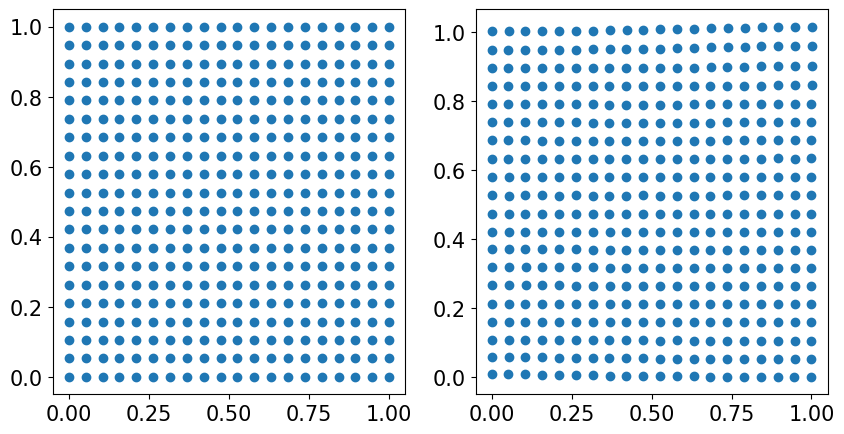

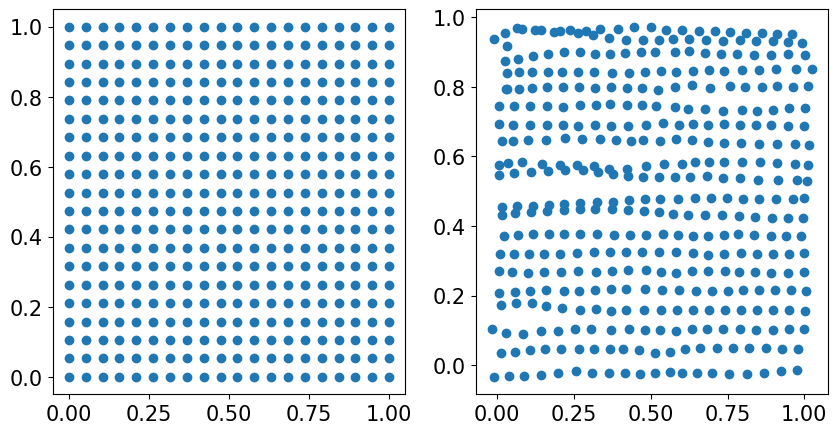

epoch: 3500, train loss: 5.832849183207145e-06, val loss: 0.00023117112868931144
epoch: 3501, train loss: 8.108380825433414e-06, val loss: 0.00020940208924002945
epoch: 3502, train loss: 1.140464792115381e-05, val loss: 0.00024274250608868897
epoch: 3503, train loss: 1.6213149137911387e-05, val loss: 0.00021681428188458085
epoch: 3504, train loss: 2.3232390958582982e-05, val loss: 0.00026588881155475974
epoch: 3505, train loss: 3.356357410666533e-05, val loss: 0.00023466043057851493
epoch: 3506, train loss: 4.878852269030176e-05, val loss: 0.00031360998400487006
epoch: 3507, train loss: 7.141210517147556e-05, val loss: 0.0002779631468001753
epoch: 3508, train loss: 0.00010484772792551666, val loss: 0.00041216504178009927
epoch: 3509, train loss: 0.00015455106040462852, val loss: 0.00038111626054160297
epoch: 3510, train loss: 0.00022728358453605324, val loss: 0.000612788659054786
epoch: 3511, train loss: 0.0003332604537717998, val loss: 0.000609904935117811
epoch: 3512, train loss: 0.0

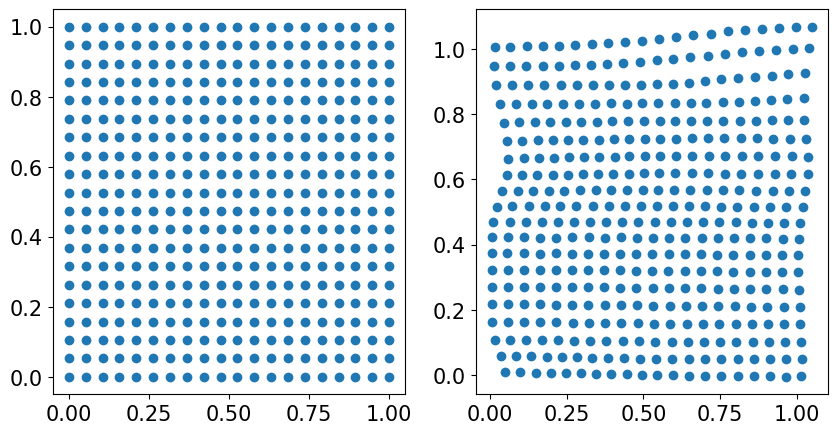

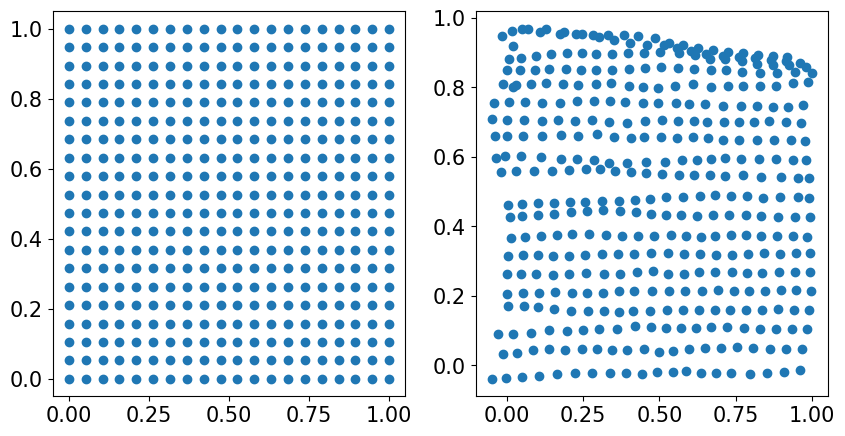

epoch: 4000, train loss: 0.00036061659920960665, val loss: 0.0006325747817754745
epoch: 4001, train loss: 0.00036115851253271103, val loss: 0.00044584012357518077
epoch: 4002, train loss: 0.0003194931778125465, val loss: 0.000474142114399001
epoch: 4003, train loss: 0.00023923492699395865, val loss: 0.0003225552209187299
epoch: 4004, train loss: 0.00014577100228052586, val loss: 0.0002496812667232007
epoch: 4005, train loss: 7.238130638143048e-05, val loss: 0.0002738192561082542
epoch: 4006, train loss: 3.981310874223709e-05, val loss: 0.00017820320499595255
epoch: 4007, train loss: 4.702979640569538e-05, val loss: 0.0003415417450014502
epoch: 4008, train loss: 7.459203334292397e-05, val loss: 0.000218496352317743
epoch: 4009, train loss: 9.900933946482837e-05, val loss: 0.00036490982165560126
epoch: 4010, train loss: 0.00010520061186980456, val loss: 0.0002372544549871236
epoch: 4011, train loss: 9.261833474738523e-05, val loss: 0.0002919358666986227
epoch: 4012, train loss: 7.1684138

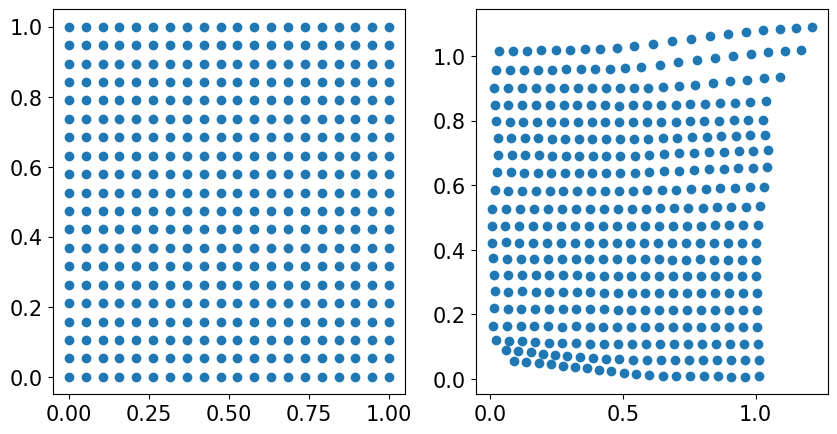

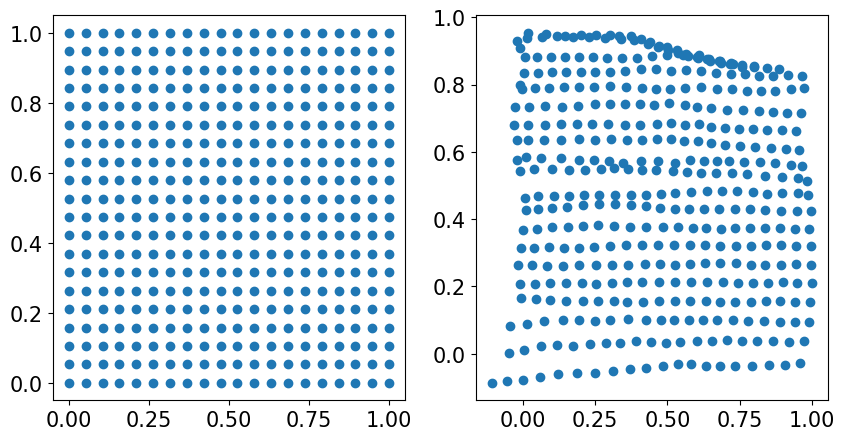

epoch: 4500, train loss: 0.0009206540416926146, val loss: 0.0016415625577792525
epoch: 4501, train loss: 0.0012632490834221244, val loss: 0.0015385146252810955
epoch: 4502, train loss: 0.0016150404699146748, val loss: 0.0023188390769064426
epoch: 4503, train loss: 0.0019079316407442093, val loss: 0.0019195358036085963
epoch: 4504, train loss: 0.0019945979584008455, val loss: 0.002195904729887843
epoch: 4505, train loss: 0.0018424972658976912, val loss: 0.0015520998276770115
epoch: 4506, train loss: 0.0015040708240121603, val loss: 0.0013455726439133286
epoch: 4507, train loss: 0.001179203623905778, val loss: 0.001310181338340044
epoch: 4508, train loss: 0.0010267543839290738, val loss: 0.0010397550649940968
epoch: 4509, train loss: 0.001109991455450654, val loss: 0.0018316177884116769
epoch: 4510, train loss: 0.0013250899501144886, val loss: 0.0013626788277179003
epoch: 4511, train loss: 0.0015801942208781838, val loss: 0.0022711039055138826
epoch: 4512, train loss: 0.00167994841467589

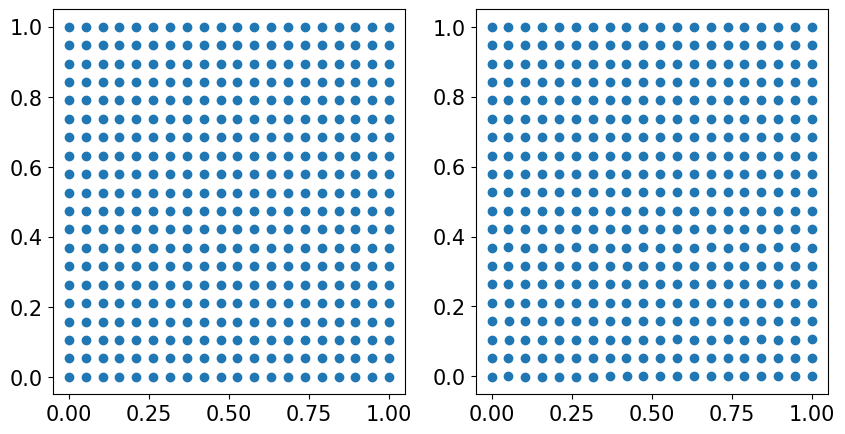

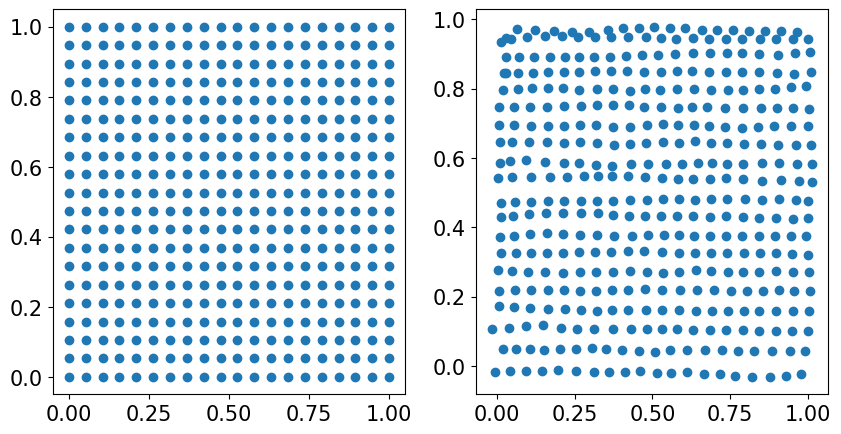

epoch: 5000, train loss: 2.8567828991299393e-08, val loss: 0.00015312315372284502
epoch: 5001, train loss: 4.3270741656442624e-08, val loss: 0.0001528252032585442
epoch: 5002, train loss: 5.3552707157678014e-08, val loss: 0.00015430217899847776
epoch: 5003, train loss: 4.428041222581669e-08, val loss: 0.0001520138030173257
epoch: 5004, train loss: 3.822968963618223e-08, val loss: 0.00015468023775611073
epoch: 5005, train loss: 4.0537234013982015e-08, val loss: 0.00015213346341624856
epoch: 5006, train loss: 3.602985287898264e-08, val loss: 0.0001541230594739318
epoch: 5007, train loss: 2.7475856256842235e-08, val loss: 0.0001529995643068105
epoch: 5008, train loss: 2.7776476230201297e-08, val loss: 0.00015306698333006352
epoch: 5009, train loss: 3.1829838320618364e-08, val loss: 0.00015397965034935623
epoch: 5010, train loss: 2.7968798832489483e-08, val loss: 0.0001524095714557916
epoch: 5011, train loss: 1.927941895019103e-08, val loss: 0.00015409009938593954
epoch: 5012, train loss: 

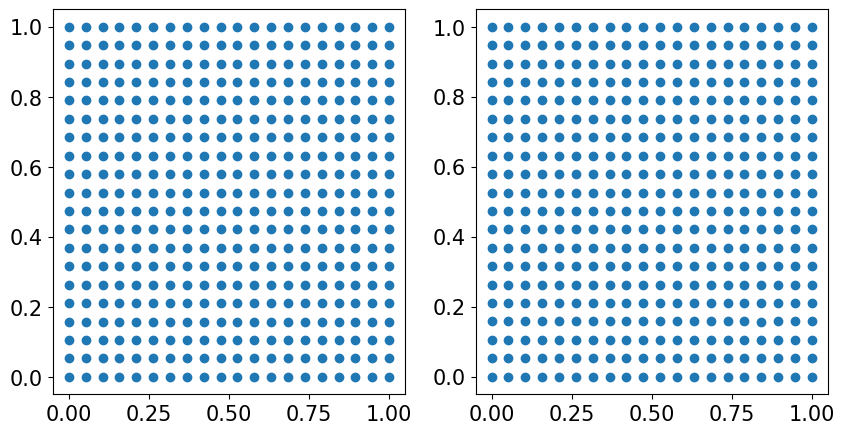

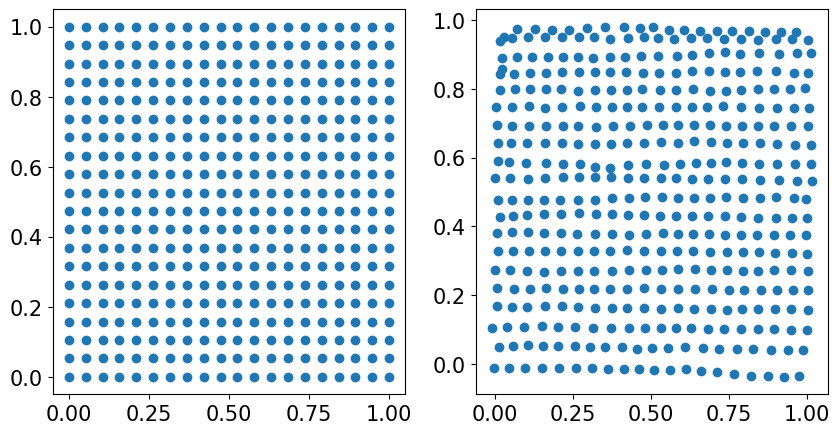

epoch: 5500, train loss: 2.863459247492983e-09, val loss: 0.00013696348469238728
epoch: 5501, train loss: 2.8180804356736644e-09, val loss: 0.00013697789108846337
epoch: 5502, train loss: 2.7788824574770388e-09, val loss: 0.00013692617358174175
epoch: 5503, train loss: 2.7070765629133575e-09, val loss: 0.00013699347618967295
epoch: 5504, train loss: 2.6486814963533334e-09, val loss: 0.00013693477376364172
epoch: 5505, train loss: 2.605603066641038e-09, val loss: 0.00013696664245799184
epoch: 5506, train loss: 2.5603452691314033e-09, val loss: 0.00013693858636543155
epoch: 5507, train loss: 2.51380982696503e-09, val loss: 0.00013697799295186996
epoch: 5508, train loss: 2.457339887129706e-09, val loss: 0.0001369110686937347
epoch: 5509, train loss: 2.42034925435064e-09, val loss: 0.00013699082774110138
epoch: 5510, train loss: 2.388506947781366e-09, val loss: 0.00013691297499462962
epoch: 5511, train loss: 2.335557747201733e-09, val loss: 0.00013697143003810197
epoch: 5512, train loss: 2

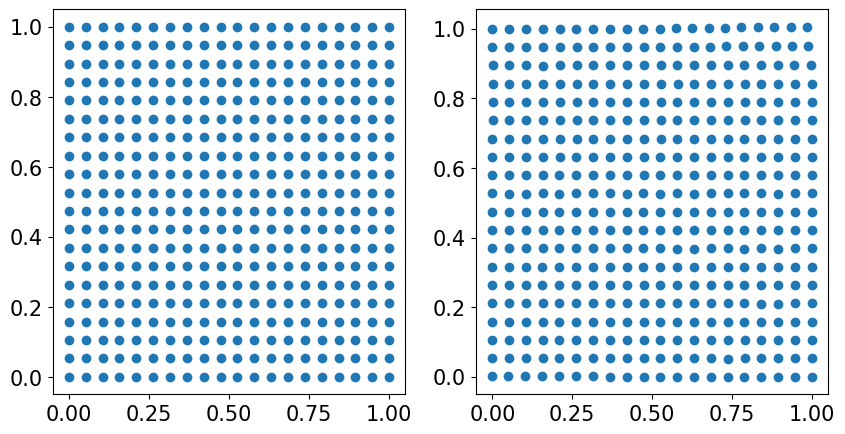

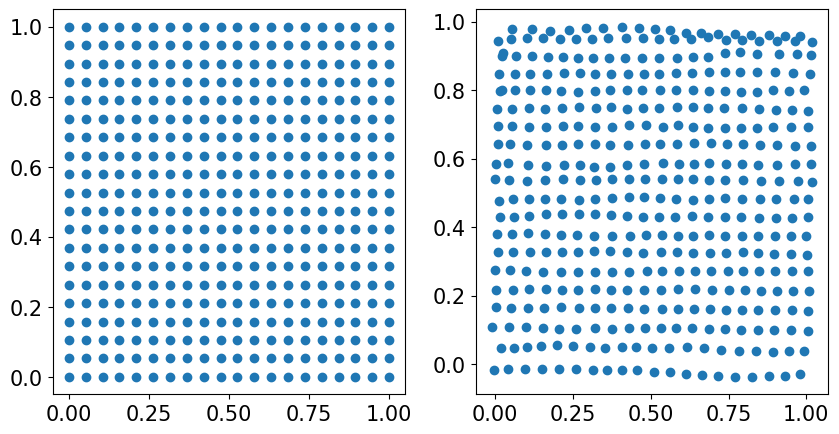

epoch: 6000, train loss: 2.309186129423324e-06, val loss: 0.0001749287184793502
epoch: 6001, train loss: 2.3833340492274147e-06, val loss: 0.00017339186160825193
epoch: 6002, train loss: 2.4327812297997298e-06, val loss: 0.00017793485312722623
epoch: 6003, train loss: 2.413695483483025e-06, val loss: 0.00017300271429121494
epoch: 6004, train loss: 2.272541678394191e-06, val loss: 0.0001757864374667406
epoch: 6005, train loss: 2.0147613213339355e-06, val loss: 0.00017596963152755052
epoch: 6006, train loss: 1.73259081748256e-06, val loss: 0.0001713628153083846
epoch: 6007, train loss: 1.5220444993246929e-06, val loss: 0.00017927808221429586
epoch: 6008, train loss: 1.3904751767768175e-06, val loss: 0.0001684126618783921
epoch: 6009, train loss: 1.2785110357071972e-06, val loss: 0.0001804521307349205
epoch: 6010, train loss: 1.1620879831752973e-06, val loss: 0.00016790747758932412
epoch: 6011, train loss: 1.0950417390631628e-06, val loss: 0.00018011809152085334
epoch: 6012, train loss: 1

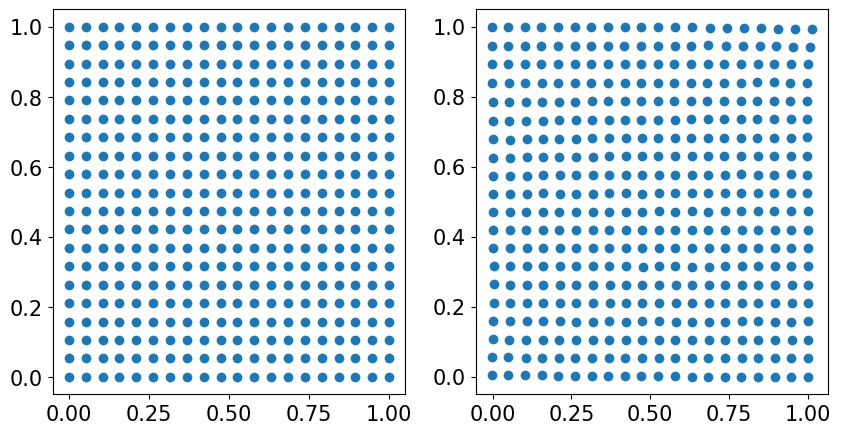

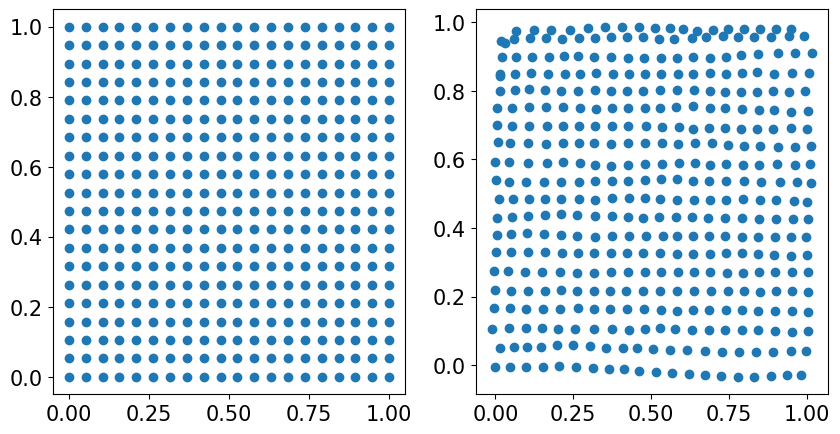

epoch: 6500, train loss: 5.250763024378102e-06, val loss: 0.00014485583233181387
epoch: 6501, train loss: 7.294675469893264e-06, val loss: 0.0001460138155380264
epoch: 6502, train loss: 6.6451693783164956e-06, val loss: 0.00013233994832262397
epoch: 6503, train loss: 4.27573195338482e-06, val loss: 0.00014398661733139306
epoch: 6504, train loss: 2.7617020350589883e-06, val loss: 0.0001312072854489088
epoch: 6505, train loss: 4.043201897729887e-06, val loss: 0.0001506168773630634
epoch: 6506, train loss: 5.879435320821358e-06, val loss: 0.00012639918713830411
epoch: 6507, train loss: 4.443290436029201e-06, val loss: 0.00014743056090082973
epoch: 6508, train loss: 1.6857868558872724e-06, val loss: 0.00013211631448939443
epoch: 6509, train loss: 1.552568960505596e-06, val loss: 0.00013337910058908165
epoch: 6510, train loss: 2.6887225885730004e-06, val loss: 0.00014626207121182233
epoch: 6511, train loss: 2.4095390926959226e-06, val loss: 0.00012602143397089094
epoch: 6512, train loss: 1.

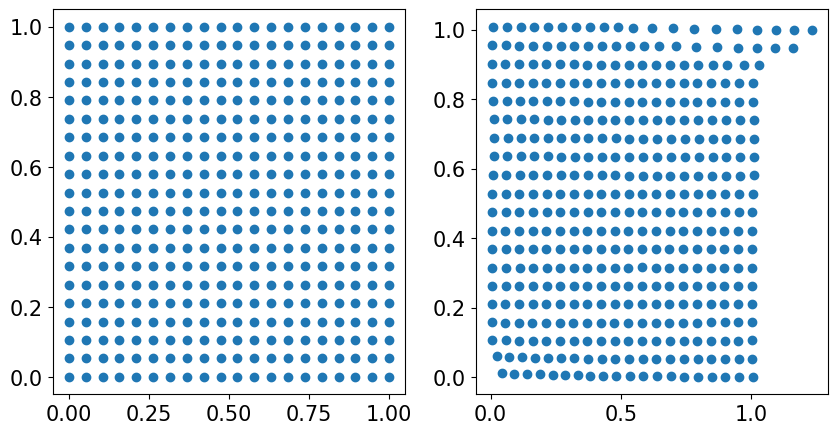

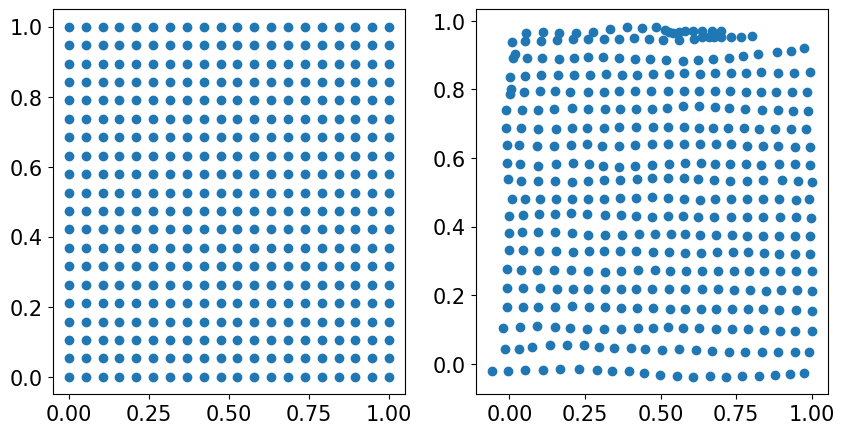

epoch: 7000, train loss: 0.0004382345068734139, val loss: 0.0008747248211875558
epoch: 7001, train loss: 0.00062507763504982, val loss: 0.0008763043442741036
epoch: 7002, train loss: 0.0008278414607048035, val loss: 0.001253207097761333
epoch: 7003, train loss: 0.0009816199308261275, val loss: 0.001039875322021544
epoch: 7004, train loss: 0.0009922725148499012, val loss: 0.0010571237653493881
epoch: 7005, train loss: 0.0008114377851597965, val loss: 0.0006219784845598042
epoch: 7006, train loss: 0.0005183048197068274, val loss: 0.00046099431347101927
epoch: 7007, train loss: 0.0002955907257273793, val loss: 0.0004563230904750526
epoch: 7008, train loss: 0.0002604878682177514, val loss: 0.00048333019367419183
epoch: 7009, train loss: 0.00039294271846301854, val loss: 0.0007707807817496359
epoch: 7010, train loss: 0.0005219271406531334, val loss: 0.0006234581815078855
epoch: 7011, train loss: 0.0005326815298758447, val loss: 0.0005896869115531445
epoch: 7012, train loss: 0.00037747717578

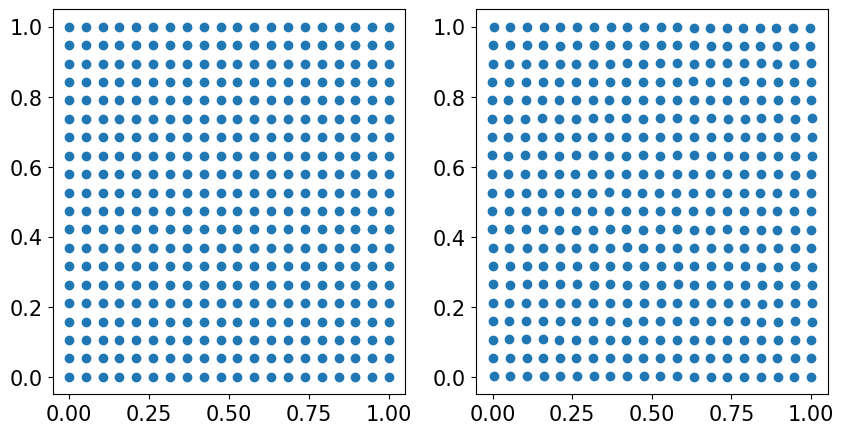

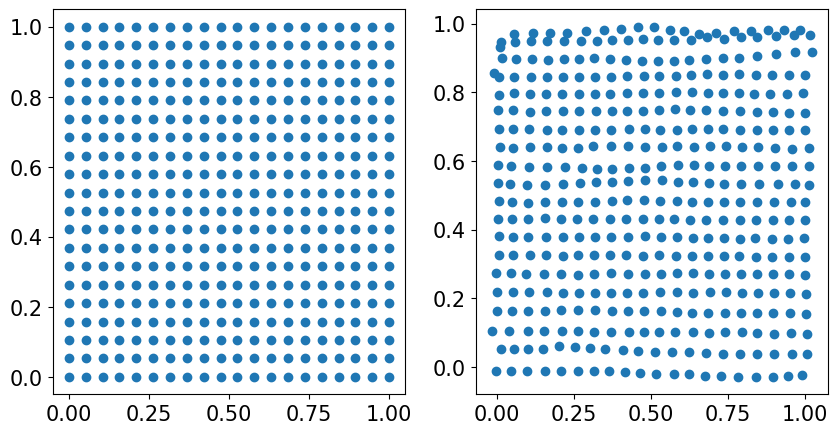

epoch: 7500, train loss: 2.233909526694333e-06, val loss: 0.00011627520871115848
epoch: 7501, train loss: 3.5177356494386913e-06, val loss: 0.00012762020924128592
epoch: 7502, train loss: 4.445323156687664e-06, val loss: 0.00011394282773835585
epoch: 7503, train loss: 3.2707334867154714e-06, val loss: 0.00012715489719994366
epoch: 7504, train loss: 1.84427005933685e-06, val loss: 0.0001148364826804027
epoch: 7505, train loss: 1.1265861985521042e-06, val loss: 0.00011292110866634175
epoch: 7506, train loss: 1.8398160364085925e-06, val loss: 0.00013175058120395988
epoch: 7507, train loss: 2.4604316877230303e-06, val loss: 0.00011195452680112794
epoch: 7508, train loss: 2.347604549868265e-06, val loss: 0.00012184619845356792
epoch: 7509, train loss: 1.0487085546628805e-06, val loss: 0.00011923204874619842
epoch: 7510, train loss: 8.466599297207722e-07, val loss: 0.00011594990064622834
epoch: 7511, train loss: 8.822085533211066e-07, val loss: 0.00012295735359657556
epoch: 7512, train loss:

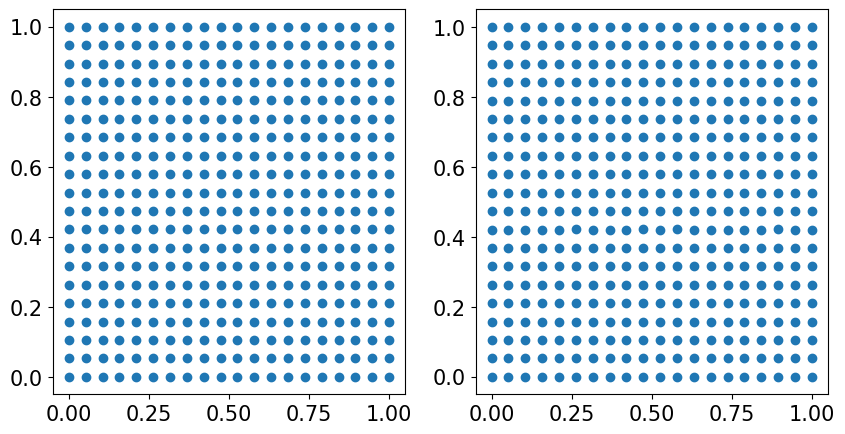

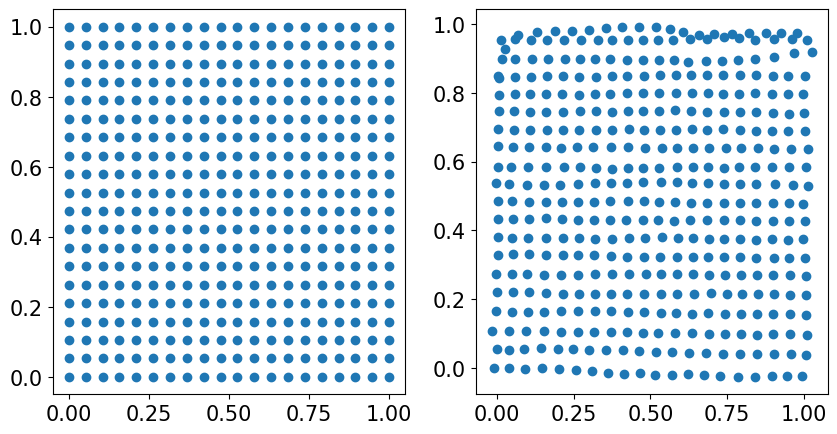

epoch: 8000, train loss: 4.603028624927674e-09, val loss: 0.00011196782725164667
epoch: 8001, train loss: 4.720465796026474e-09, val loss: 0.00011119436385342851
epoch: 8002, train loss: 4.864193936526817e-09, val loss: 0.00011204301699763164
epoch: 8003, train loss: 5.100755817721847e-09, val loss: 0.0001112174431909807
epoch: 8004, train loss: 5.3349968887062005e-09, val loss: 0.00011196417472092435
epoch: 8005, train loss: 5.389158452828724e-09, val loss: 0.00011132735380670056
epoch: 8006, train loss: 5.211147513506376e-09, val loss: 0.00011186295887455344
epoch: 8007, train loss: 4.936567155056082e-09, val loss: 0.00011143123265355825
epoch: 8008, train loss: 4.751468107855317e-09, val loss: 0.00011181113950442523
epoch: 8009, train loss: 4.750632331962379e-09, val loss: 0.00011139007983729243
epoch: 8010, train loss: 4.883946580491738e-09, val loss: 0.00011188883217982948
epoch: 8011, train loss: 5.025343696729578e-09, val loss: 0.00011131713108625263
epoch: 8012, train loss: 5.1

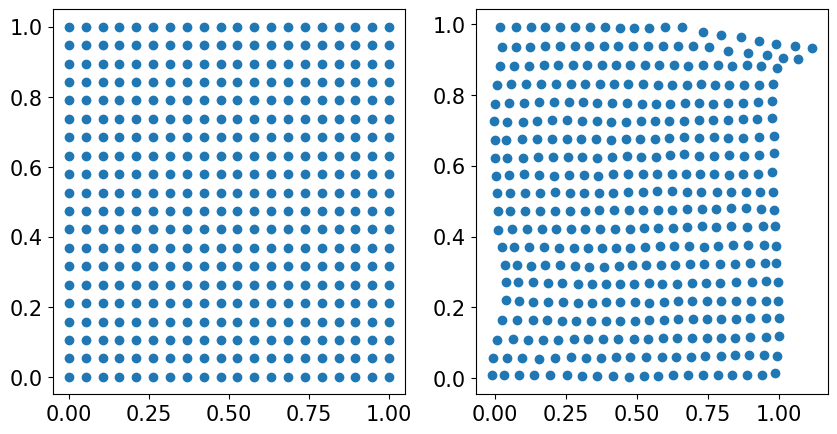

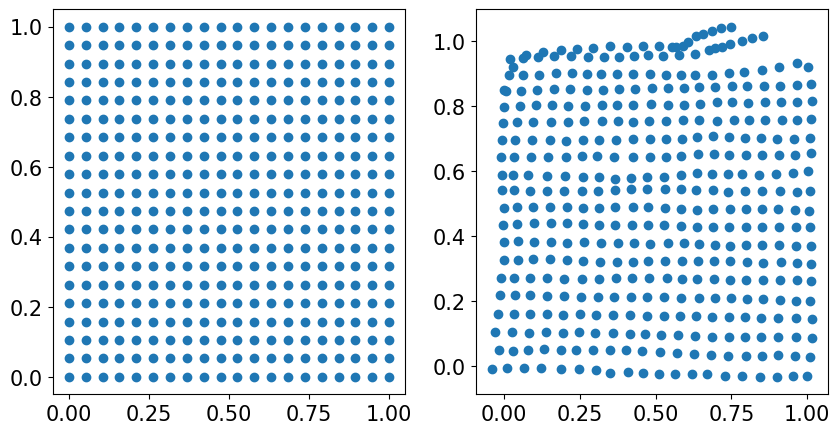

epoch: 8500, train loss: 0.00023567093012388796, val loss: 0.0006172508001327515
epoch: 8501, train loss: 0.0004205253499094397, val loss: 0.0006377786048687994
epoch: 8502, train loss: 0.0006019912543706596, val loss: 0.0006075060809962451
epoch: 8503, train loss: 0.00044993855408392847, val loss: 0.000307164853438735
epoch: 8504, train loss: 0.00020836060866713524, val loss: 0.0002321859064977616
epoch: 8505, train loss: 9.699921793071553e-05, val loss: 0.00017048923473339528
epoch: 8506, train loss: 7.196989463409409e-05, val loss: 0.00028096346068196
epoch: 8507, train loss: 0.0001559181691845879, val loss: 0.0003464547044131905
epoch: 8508, train loss: 0.00021408486645668745, val loss: 0.00021144229685887694
epoch: 8509, train loss: 0.00012272738968022168, val loss: 0.0001738054124871269
epoch: 8510, train loss: 4.218768299324438e-05, val loss: 0.0001526235428173095
epoch: 8511, train loss: 4.188490129308775e-05, val loss: 0.00018478732090443373
epoch: 8512, train loss: 7.51430197

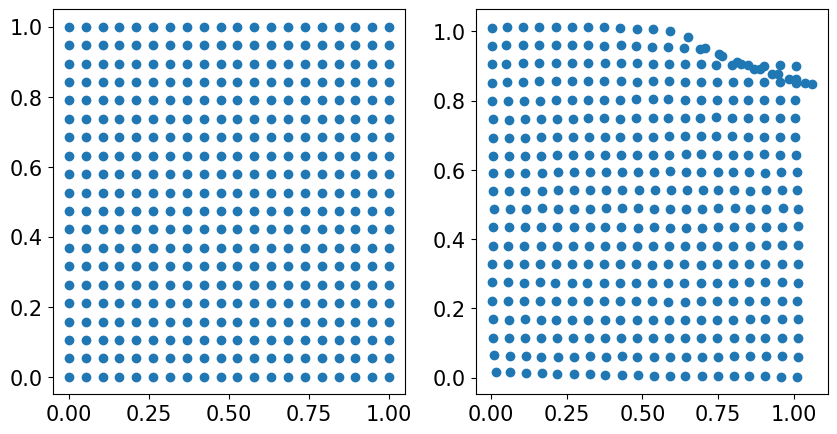

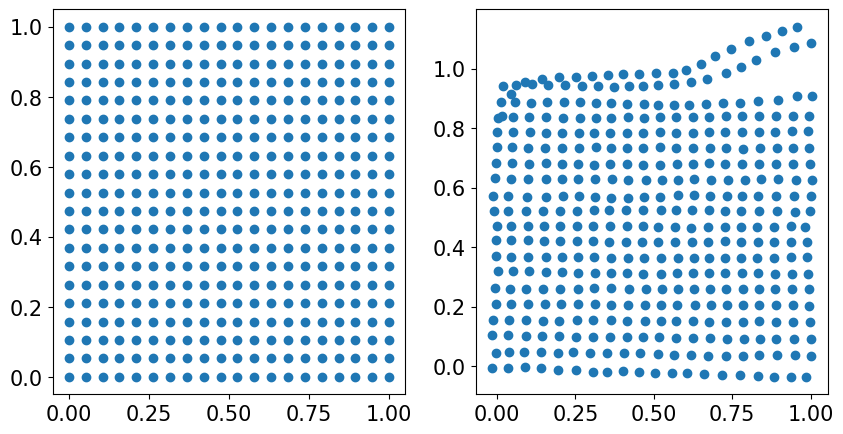

epoch: 9000, train loss: 0.0002711669949349016, val loss: 0.0002886512374971062
epoch: 9001, train loss: 0.000256659317528829, val loss: 0.0002748549450188875
epoch: 9002, train loss: 0.00012746971333399415, val loss: 0.00012347032316029072
epoch: 9003, train loss: 3.52684837707784e-05, val loss: 0.0001334018015768379
epoch: 9004, train loss: 6.787212623748928e-05, val loss: 0.00030382900149561465
epoch: 9005, train loss: 0.000153041779412888, val loss: 0.00021565516362898052
epoch: 9006, train loss: 0.00017161424329970032, val loss: 0.00022139656357467175
epoch: 9007, train loss: 0.00010066031973110512, val loss: 0.0001298163551837206
epoch: 9008, train loss: 3.106279837084003e-05, val loss: 8.155652176355943e-05
epoch: 9009, train loss: 3.0467635951936245e-05, val loss: 0.0002089748886646703
epoch: 9010, train loss: 6.775401561753824e-05, val loss: 0.00012549178791232407
epoch: 9011, train loss: 7.947428821353242e-05, val loss: 0.0001544221449876204
epoch: 9012, train loss: 5.2933286

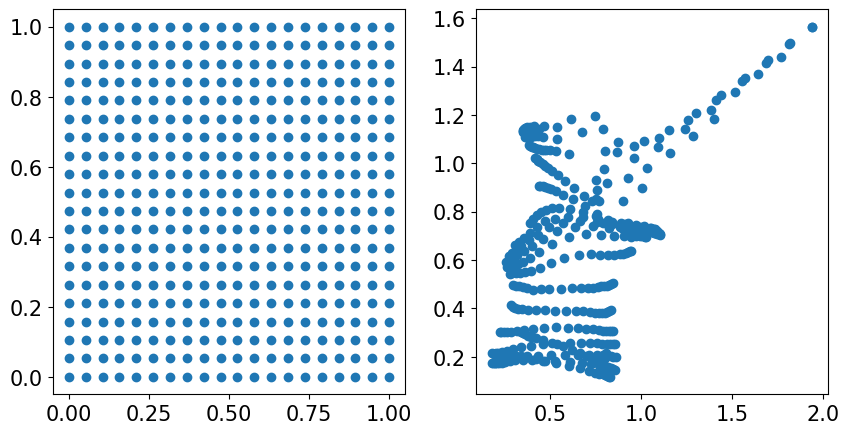

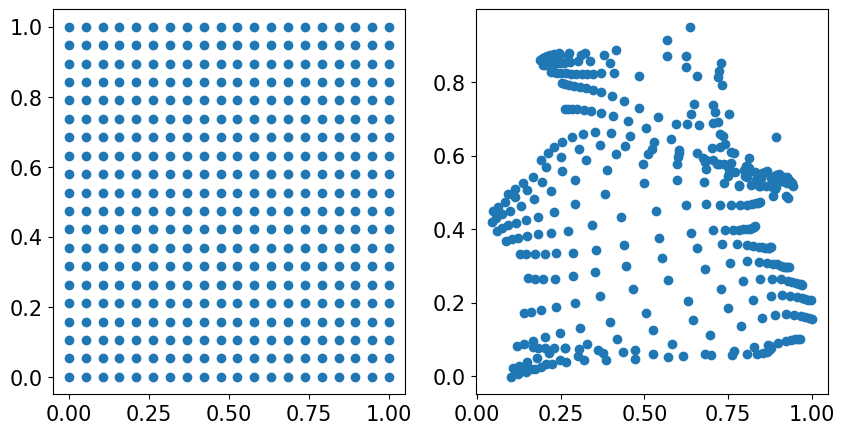

epoch: 9500, train loss: 0.041862934827804565, val loss: 0.012542194686830044
epoch: 9501, train loss: 0.012583348900079727, val loss: 0.02367878146469593
epoch: 9502, train loss: 0.024284180253744125, val loss: 0.012855594046413898
epoch: 9503, train loss: 0.01386226899921894, val loss: 0.012774800881743431
epoch: 9504, train loss: 0.011871772818267345, val loss: 0.01350308395922184
epoch: 9505, train loss: 0.012073850259184837, val loss: 0.007023555692285299
epoch: 9506, train loss: 0.007216754835098982, val loss: 0.010295161046087742
epoch: 9507, train loss: 0.01098420936614275, val loss: 0.004046217072755098
epoch: 9508, train loss: 0.00426151929423213, val loss: 0.00661470927298069
epoch: 9509, train loss: 0.006050210911780596, val loss: 0.0070905196480453014
epoch: 9510, train loss: 0.006405435036867857, val loss: 0.0018020522547885776
epoch: 9511, train loss: 0.0018381511326879263, val loss: 0.004487201571464539
epoch: 9512, train loss: 0.004799135960638523, val loss: 0.00387925

In [6]:
#cc data training #(x, y) coords 
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

grid=np.array(mat73.loadmat(data_path+'/grid.mat')['full_grid'])
b_x=min(grid[:,0])
m_x=(max(grid[:,0])-min(grid[:,0]))
b_y=min(grid[:,1])
m_y=(max(grid[:,1])-min(grid[:,1]))
x_rescal=lambda x: (x-b_x)/m_x
y_rescal=lambda y: (y-b_y)/m_y
labeled_data=400
layer_loss_list=[]
Epochs=10000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC_XY_targs(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5, xpix=20, ypix=20, font_size=15)
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')


#torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [14]:
#Checks if theres a  1-1 correspondence b/w ghat ghat^* and g g^*
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

decoder=nn.Linear(400,1450*2, bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
decoder.load_state_dict(torch.load(locat))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
medium=medium.T
print(medium_hat.shape, medium.shape)
cc_medium_hat=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium_hat.append(outer)

cc_medium_hat=np.array(cc_medium_hat)
cc_medium=[]
for i in range(len(medium)):
    outer=np.outer(medium[i],medium[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium.append(outer)
cc_medium=np.array(cc_medium)

G_hat_permed=np.zeros_like(medium_hat)

torch_inners=np.abs(np.inner(cc_medium_hat,cc_medium.conj()) ) #entry i j is ghat_i dot bar(g_j) 
# mean over true max over hats
torch_inners=torch.tensor(torch_inners)
for i in range(400):
    largest,indices_1=torch.max(torch_inners, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    torch_inners[:,indices_1[overall_max_index]]=0

print(G_hat_permed.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.conj()) ) #entry i j is ghat_i dot bar(g_j)
print(sum(torch_inners.diagonal())/400)




(400, 1450) (400, 1450)
(400, 1450)
0.9302892977489609


((1450, 1450), (1450, 1450))

In [ ]:
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)
